this notebook does some spot checking on learned weight patterns in `scripts/training/yuanyuan_8k_a_3day/feature_approximation/local_pcn_recurrent/submit_sep2.py`.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.training.training_aux import load_training_results

In [3]:
from sys import path
from os.path import join, exists, dirname
from os import makedirs



In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/feature_approximation/k_bl_recurrent_k3'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_sep2 import param_iterator

In [5]:
from numpy.linalg import norm
import numpy as np

In [6]:
from sklearn.decomposition import PCA
from pickle import dump

In [7]:


def calc_raw_stats(weight_matrix):
    # weight_matrix is N * D
    # N = number of filters
    # D = size of a (flattened) filter.
    mean_all = weight_matrix.mean(axis=1)
    std_all = weight_matrix.std(axis=1)
    print('mean_all', mean_all.mean(), mean_all.std())
    print('std_all', std_all.mean(), std_all.std())
    
def calc_normed_pca(weight_matrix, verbose=False):
    # here `normed` means PCA after normalization of weight_matrix
    
    # there are multiple ways to define `normalization`
    # 
    # a simple way is to make each flattened filter with unit norm.
    weight_matrix_norm = norm(weight_matrix, axis=1, keepdims=True)
#     assert weight_matrix_norm.shape == (256,1)
    weight_matrix_normed = weight_matrix/weight_matrix_norm
    
    # tested, works as expected.
    if verbose:
        assert np.allclose(norm(weight_matrix_normed, axis=1), 1.0)
    
    
    # then let's do PCA
    pca_obj = PCA(svd_solver='full')
    pca_obj.fit(weight_matrix_normed)
    if verbose:
        # top 10 explains 60%;
        # top 20 explains 85%;
        # looks fine to me, compared to https://doi.org/10.1101/677237
        # "Recurrent networks can recycle neural resources to flexibly trade speed for accuracy in visual recognition"
        
        print(np.cumsum(pca_obj.explained_variance_ratio_)[:20])
        print(pca_obj.components_.shape)
    
    # then let's return and save them.
    return {
        'weight_matrix_norm': weight_matrix_norm,
        'weight_matrix': weight_matrix,
        'components': pca_obj.components_,
        'explained_variance_ratio': pca_obj.explained_variance_ratio_,
    }

def construct_back_by_interleave(x1, x2, by1, by2):
    n1, m1 = x1.shape
    n2, m2 = x2.shape
    assert n1 % by1 == 0
    assert n2 % by2 == 0
    assert m1==m2 and n1//by1 == n2//by2
    
    x1 = x1.reshape(n1//by1, by1, m1)
    x2 = x2.reshape(n2//by2, by2, m2)
    return np.concatenate((x1,x2), axis=1).reshape((n1+n2, m1))


def save_one_result(filename, data):
    makedirs(dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        dump(data, f)

In [8]:
# create dir
global_vars = {
    'save_dir': join(dir_dict['analyses'],
                     'yuanyuan_8k_a_3day+feature_approximation+k_bl_recurrent_k3+submit_sep2+0',
                    'pca')
}

def prepare_dir():
    save_dir = global_vars['save_dir']
    if not exists(save_dir):
        makedirs(save_dir)
prepare_dir()

In [9]:
def collect_all():
    save_dir = global_vars['save_dir']
    count = 0
    for idx, data in enumerate(param_iterator(sep_start_range=(0,))):
        count += 1
        verbose = idx % 5 == 0

        key = data['key_this_original']
        
        def filename_gen(x):
            return join(save_dir, f'{idx}/unit_norm', f'{x}.pkl')
        
        filename_set = {'ff', 'lateral', 'all'}
        if all([exists(filename_gen(x)) for x in filename_set]):
            # right now if partially done, the partial results will be fully overwritten.
            continue
        # then load weights.
        result = load_training_results(key, return_model=False, return_checkpoint=True)
        
        loss_curves = sum([ [y['train'] for y in x] for x in result['stats_all']], [])
#         print(len(loss_curves))
        if verbose:
            # plot the curve
            plt.close('all')
            plt.figure(figsize=(10, 3))
            plt.plot(loss_curves)
            plt.show()
        
        # use float64 for all analysis to retain precision.
        weight_np = result['checkpoint']['model']['moduledict.conv0.weight'].numpy().astype(np.float64)
#         print(weight_np.dtype)
#         print(weight_np.shape)
        
        # here this num_c_lower contains both the true input, as well as layer1's last output.
        # num_c_higher is for layer2's output.
        num_c_higher, num_c_lower = weight_np.shape[0], weight_np.shape[1] - weight_np.shape[0]
        assert len(weight_np.shape)==4
        kernel_shape = weight_np.shape[2:]
        assert kernel_shape == (9,9)
        kernel_numel = kernel_shape[0]*kernel_shape[1]
        # according to the way I write the model (scripts/training/yuanyuan_8k_a_3day/feature_approximation/local_pcn_recurrent/master.py),
        # in the `32` part of (16, 32, k, k), first 16 channels are input from lower layer.
        weight_np_ff = weight_np[:,:num_c_lower]
        # rest 16 channels are input from recurrent layer.
        weight_np_lateral = weight_np[:,num_c_lower:]
#         print(weight_np_ff.shape, weight_np_lateral.shape)
        assert weight_np_ff.shape == (num_c_higher, num_c_lower) + kernel_shape
        assert weight_np_lateral.shape == (num_c_higher, num_c_higher) + kernel_shape
        
        weight_np_ff = weight_np_ff.reshape((num_c_higher*num_c_lower, kernel_shape[0]*kernel_shape[1]))
        weight_np_lateral = weight_np_lateral.reshape((num_c_higher*num_c_higher, kernel_shape[0]*kernel_shape[1]))
        
        channel_shape_all = weight_np.shape[:2]
        
        new_shape_all = (channel_shape_all[0]*channel_shape_all[1], kernel_shape[0]*kernel_shape[1])
        
        weight_np_all = weight_np.reshape(new_shape_all)
        weight_np_all_debug = construct_back_by_interleave(weight_np_ff, weight_np_lateral,by1=num_c_lower,by2=num_c_higher)
        
        
        
#         print(weight_np_all_debug.shape)
        assert np.array_equal(
            weight_np_all,
            weight_np_all_debug,
        )
#         print(weight_np_lateral.shape, weight_np_ff.shape)
        
        if verbose:
            print('idx', idx)
            print('key', key)
            # show some raw stats.
            calc_raw_stats(weight_np_ff)
            calc_raw_stats(weight_np_lateral)
            calc_raw_stats(weight_np_all)
        pca_res_dict = dict()
        pca_res_dict['ff'] = calc_normed_pca(weight_np_ff, verbose)
        pca_res_dict['lateral'] = calc_normed_pca(weight_np_lateral, verbose)
        pca_res_dict['all'] = calc_normed_pca(weight_np_all, verbose)
        
        # simply store it as pickle, for simplicity.
        
#         data_to_save = {
#             'idx': idx,
#             'key': key,
#             'ff': pca_res_ff,
#             'lateral': pca_res_lateral,
#             'all': pca_res_all,
#         }
        
        # then save.
        # I think it's good to save as `idx/unit_norm/ff|lateral|all/data.pkl`;
        # this way, I can extend as needed.
        
        for fn in filename_set:
            save_one_result(filename_gen(fn), pca_res_dict[fn])
        
    print(count)


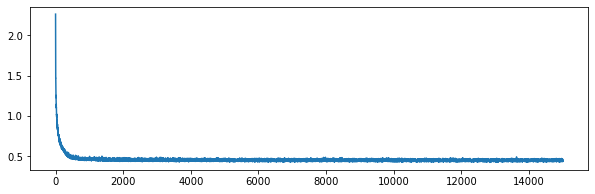

idx 0
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx38/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0007723302537833991 0.007178781398057698
std_all 0.022760379783749132 0.007820844829362475
mean_all 6.336078136762437e-05 0.004879560817421996
std_all 0.02556898412857445 0.020066186989624164
mean_all -0.0004937665753997247 0.006515251461778134
std_all 0.023696581232024238 0.013294634593236076
[0.13981877 0.2534634  0.36394105 0.43115802 0.48536888 0.53154381
 0.57421146 0.61263477 0.64520319 0.67289117 0.69894797 0.72092441
 0.74161889 0.759997   0.77783376 0.79327451 0.8079556  0.8217168
 0.8350834  0.84680302]
(81, 81)
[0.17575284 0.34737226 0.47798397 0.59472373 0.67791265 0.73677163
 0.77828998 0.80891582 0.83568015 0.8566054  0.87593617 0.89053731
 0.90385908 0.91629403 0.92623242 0.93526468 0.94225152 0.94878203
 0.95445829 0.95945041]
(64, 81)
[0.13656395 0.26130381 0.38434466 0.45525712 0.51360859 0.56637393
 0.60757903 0.64441492 0.6745001

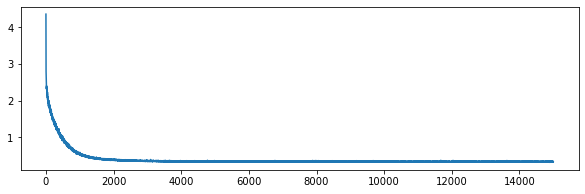

idx 5
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx38/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0009889933781524604 0.009210315268137639
std_all 0.028512947396656843 0.008451479804234068
mean_all -3.1844295066048745e-05 0.009498209749072293
std_all 0.032038279033365376 0.011520727029199897
mean_all -0.0006699436837903234 0.009318200100863292
std_all 0.029688057942226353 0.009727409415494305
[0.14893809 0.26279047 0.36068669 0.4324771  0.49123122 0.54010924
 0.57806914 0.61269927 0.64590232 0.67422318 0.70062146 0.72377886
 0.74388228 0.76341462 0.78068674 0.79607873 0.81011375 0.82367899
 0.83635832 0.84769457]
(81, 81)
[0.24780535 0.40680802 0.55026574 0.65562045 0.7296062  0.7813786
 0.8156205  0.84239698 0.86351533 0.8820624  0.89625905 0.90971718
 0.92036962 0.92960881 0.93862163 0.94635239 0.95226901 0.95731115
 0.96228637 0.9667084 ]
(64, 81)
[0.17330727 0.29652228 0.40371175 0.47538295 0.53277714 0.58132518
 0.622052  

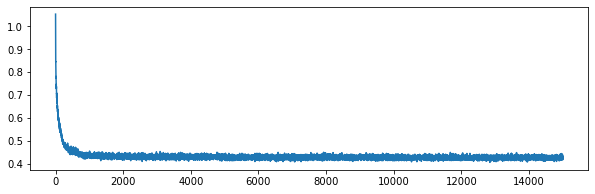

idx 10
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx39/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0006719819837476227 0.00895201213531202
std_all 0.028195071981610996 0.03300439451043597
mean_all -0.0004217045260093911 0.00448132880464587
std_all 0.026825626568875625 0.02375972519335677
mean_all 0.00030741981382861834 0.007770816856489681
std_all 0.02773859017736587 0.030245412374388644
[0.19196577 0.30340666 0.3796891  0.44587889 0.50464161 0.55419458
 0.59339749 0.62942086 0.66198356 0.68948152 0.71447235 0.73639937
 0.75724732 0.77401649 0.79032345 0.80410139 0.81701288 0.8294965
 0.84124282 0.85215555]
(81, 81)
[0.18971318 0.35953316 0.51338304 0.63076034 0.70863773 0.7668239
 0.80654981 0.83485462 0.85748335 0.87637995 0.89357427 0.90683638
 0.9191424  0.9300126  0.9401203  0.94817159 0.95415284 0.95975135
 0.96469468 0.96897996]
(64, 81)
[0.17813216 0.30808094 0.39760518 0.48060661 0.54438283 0.59201918
 0.63225944 0.6682117  0.69647628 0.7

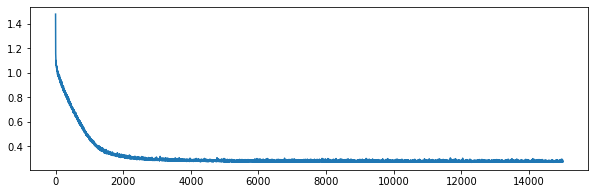

idx 15
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx39/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0013331783248205996 0.009920166752438482
std_all 0.03460097316499787 0.010747971978326448
mean_all 4.6420935457446564e-05 0.00870532931057412
std_all 0.03463056846867235 0.011920643741980751
mean_all -0.0008733119047279178 0.00955459815906955
std_all 0.034610838266222695 0.011152580186341618
[0.21639274 0.31830253 0.39469097 0.46241255 0.52081624 0.57104947
 0.61296394 0.64907933 0.6830864  0.71197733 0.73320849 0.7525935
 0.77091115 0.78798092 0.8035877  0.81730088 0.83012588 0.84160533
 0.85283437 0.86309734]
(81, 81)
[0.26757166 0.43640861 0.57463443 0.68244733 0.76240603 0.83281649
 0.86130014 0.88573467 0.90504088 0.92025897 0.93166038 0.94014317
 0.94845478 0.9549886  0.96047837 0.9654812  0.96984896 0.97351415
 0.97697989 0.97966765]
(64, 81)
[0.22076906 0.33719648 0.42952602 0.50960033 0.57057229 0.62183295
 0.66038902 0.69

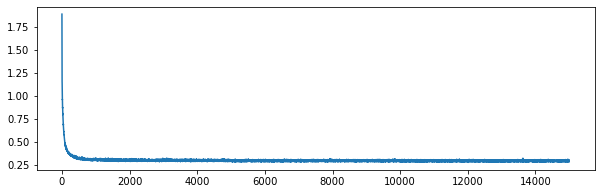

idx 20
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx102/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00032485041281041883 0.005755572114725762
std_all 0.01811780182041116 0.006761718534555198
mean_all -0.00015848678230269571 0.004534907565197094
std_all 0.01844063801450365 0.01999685399656282
mean_all -0.0002693958693078445 0.00538011953395306
std_all 0.01822541388510866 0.012798246324917016
[0.18828546 0.30588286 0.38253375 0.44408098 0.49412041 0.53365737
 0.57090149 0.6007285  0.62538937 0.64894484 0.66973818 0.68924974
 0.70684755 0.72329194 0.738824   0.7529059  0.7653422  0.77726414
 0.78832272 0.79909205]
(81, 81)
[0.24816617 0.40714315 0.52520697 0.61646226 0.67042995 0.71678683
 0.75232783 0.78148404 0.80134668 0.81873856 0.83583085 0.85151903
 0.86518165 0.87660758 0.88676804 0.89658627 0.90480618 0.9118591
 0.91865826 0.92474029]
(81, 81)
[0.20668435 0.33334808 0.41956201 0.48794078 0.53443344 0.57563647
 0.61007076 0.64216063 0.66

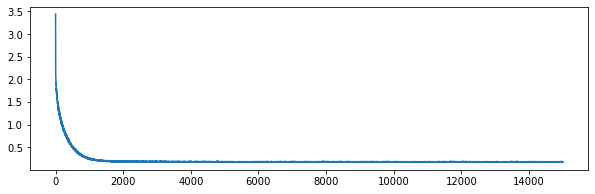

idx 25
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx103/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00042675542357596805 0.012757278219380667
std_all 0.02433373658952949 0.008042340382089149
mean_all 0.000865870673852655 0.01144230306089868
std_all 0.02944296310885686 0.013808484714467535
mean_all 4.119942233572977e-06 0.012349581854675471
std_all 0.02603681209597195 0.010605588539952457
[0.22852695 0.32603121 0.39472751 0.44988745 0.49636786 0.53766494
 0.57672565 0.60743278 0.63358371 0.65696945 0.6787828  0.69961861
 0.71966265 0.73678694 0.75158397 0.76482401 0.77763138 0.78940197
 0.79995947 0.8098326 ]
(81, 81)
[0.33434928 0.5353613  0.63188702 0.71466997 0.76453441 0.80064835
 0.83201316 0.85466369 0.87391391 0.88890197 0.90014778 0.91094352
 0.91903697 0.92629194 0.93275622 0.93859131 0.94420929 0.94876077
 0.95328448 0.95687103]
(81, 81)
[0.25465259 0.38119182 0.45465436 0.51942662 0.56272365 0.60216406
 0.63863031 0.67007

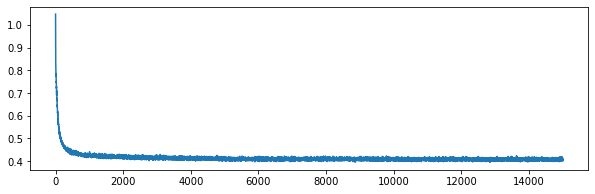

idx 30
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx103/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0005030028578320016 0.01413524117546686
std_all 0.027764279129613878 0.023671116330890994
mean_all 5.799873654749573e-05 0.011070328331275858
std_all 0.03247513085358301 0.04780908929819528
mean_all -0.0003160023263721691 0.013195606222427145
std_all 0.02933456303760359 0.0337695487361721
[0.21901142 0.31833955 0.40595937 0.46162547 0.50431477 0.54381353
 0.57797893 0.60938513 0.63860575 0.66392181 0.6854027  0.70471587
 0.72390573 0.7409638  0.75596564 0.77080035 0.78310962 0.79503284
 0.80525529 0.81504631]
(81, 81)
[0.2327373  0.4049505  0.51280082 0.60256995 0.66868634 0.71386812
 0.75189665 0.78059936 0.80681381 0.82793689 0.84377572 0.8589219
 0.87153027 0.88270087 0.89164897 0.89940679 0.90670054 0.91320245
 0.9192123  0.924724  ]
(81, 81)
[0.2210185  0.33459142 0.43115757 0.49478644 0.54105832 0.58007297
 0.61587305 0.64654319 0.6734117

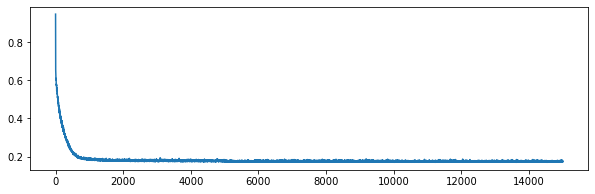

idx 35
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx166/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -6.573623652642821e-05 0.01193889892387714
std_all 0.02663868127839171 0.008164788901296812
mean_all 0.0003425031520097164 0.014604108938448651
std_all 0.032096390044984865 0.014671113286205116
mean_all 7.034355965228666e-05 0.012890121788676703
std_all 0.028457917533922763 0.011081919869510808
[0.18396776 0.27519218 0.34549331 0.4081231  0.45169254 0.49161801
 0.52888692 0.56357325 0.59139058 0.61742738 0.64147161 0.66266069
 0.68216653 0.70012367 0.7164455  0.73241025 0.7466296  0.76008076
 0.77230706 0.783591  ]
(81, 81)
[0.37409082 0.52864748 0.63397158 0.69979465 0.73466916 0.7666861
 0.7935168  0.81743652 0.83411893 0.84908425 0.86105421 0.87189398
 0.88121717 0.88997239 0.8975727  0.9044445  0.91062191 0.91619177
 0.92116757 0.92599539]
(81, 81)
[0.24039833 0.34722652 0.42191854 0.48746513 0.53076643 0.56789054
 0.60183265 0.63262

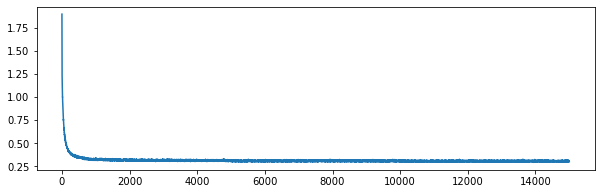

idx 40
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx167/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0002569089657677043 0.008579328533836174
std_all 0.022254264256649992 0.007144785833711464
mean_all 0.00015717326711205273 0.007237960154555574
std_all 0.022921605297133225 0.02412933019184775
mean_all -0.00011888155480778522 0.008159087628303037
std_all 0.022476711270144407 0.015106482060904616
[0.20800534 0.31013579 0.38697194 0.44312931 0.48664486 0.5214005
 0.55513946 0.58621796 0.61236342 0.63584155 0.656239   0.67526805
 0.69321515 0.71067978 0.72702201 0.74068995 0.7522237  0.76329769
 0.77408611 0.78435034]
(81, 81)
[0.2848104  0.41195077 0.49910971 0.58135009 0.62615091 0.66914093
 0.70924192 0.74011251 0.76302972 0.78046475 0.79614799 0.81101227
 0.82531867 0.83813516 0.84988395 0.86012754 0.86995521 0.87813462
 0.88501859 0.89156776]
(81, 81)
[0.22895185 0.32531043 0.4144192  0.47791418 0.52047645 0.55863417
 0.5918361  0.6238117  0.647

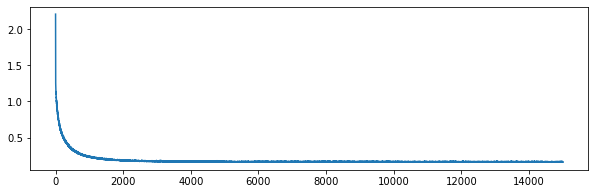

idx 45
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx167/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0005327522357678359 0.011293533302896903
std_all 0.025562202113641692 0.007236368261610809
mean_all 0.00024746647926395107 0.012699239240394657
std_all 0.030530149801214553 0.011639555978408817
mean_all -0.0002726793307572402 0.011786493593764944
std_all 0.02721818467616598 0.009249558261418324
[0.19180003 0.28406213 0.35556719 0.41848871 0.45963082 0.49971056
 0.53853876 0.57307659 0.59837296 0.62239191 0.64482577 0.66559336
 0.68528337 0.70393364 0.7212504  0.7353429  0.7479295  0.76001334
 0.77147973 0.78228838]
(81, 81)
[0.36045435 0.50547191 0.59763171 0.66721478 0.709954   0.74913894
 0.7800486  0.80675497 0.82443348 0.83840938 0.85131833 0.8633292
 0.87461055 0.88381673 0.89224909 0.90027598 0.90774116 0.91465009
 0.91999405 0.92487316]
(81, 81)
[0.24302728 0.34801246 0.42260482 0.48479318 0.52671927 0.56468715
 0.59969477

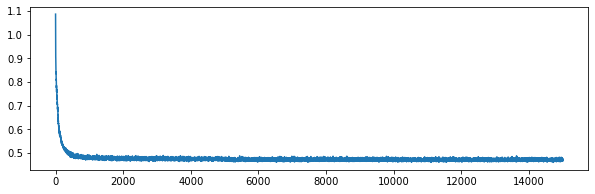

idx 50
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx230/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.000393402015680671 0.01177130533601498
std_all 0.02413815583289166 0.01137681129412674
mean_all -0.001014034580226791 0.006365130782298554
std_all 0.027320913108852082 0.02180859327005405
mean_all -0.0006002795371960443 0.010293994015227263
std_all 0.025199074924878467 0.015718690645019164
[0.18544506 0.28804184 0.36300169 0.42865479 0.48220628 0.52588746
 0.56138525 0.59620949 0.63008715 0.6594895  0.68300991 0.70639378
 0.72729016 0.74756539 0.76443441 0.77968439 0.79459482 0.80775051
 0.81985558 0.8314665 ]
(81, 81)
[0.20077267 0.36378346 0.49422043 0.57573841 0.6394304  0.69387001
 0.73457605 0.76501147 0.79310273 0.81908103 0.83990053 0.85613551
 0.87229732 0.88624602 0.8989988  0.91067198 0.920842   0.92973265
 0.9380086  0.94526102]
(64, 81)
[0.17335061 0.29156542 0.37922593 0.44076815 0.49969736 0.54531572
 0.5859423  0.61826982 0.64804454 

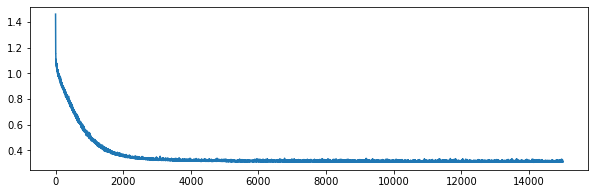

idx 55
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx230/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00028218339705908974 0.012688880464820137
std_all 0.03418145148300768 0.011123084530597968
mean_all -0.0006642914079662493 0.00908121294484784
std_all 0.033638257941124704 0.013086855093276395
mean_all -0.00040955273402814283 0.011612940212519535
std_all 0.03400038696904669 0.011816774818471206
[0.18971814 0.30297411 0.3932117  0.47741958 0.53309566 0.57793613
 0.6147522  0.64800201 0.67748635 0.70392571 0.72864274 0.75108516
 0.77081826 0.78805685 0.80422465 0.81864793 0.83181156 0.84344138
 0.85458421 0.86527794]
(81, 81)
[0.24956078 0.41476112 0.56611462 0.65959713 0.72871513 0.7868156
 0.82058133 0.84980612 0.87225451 0.89040419 0.90384049 0.91540677
 0.92470927 0.93327696 0.94098975 0.94758346 0.95358844 0.95865397
 0.96316193 0.96729674]
(64, 81)
[0.2057219  0.32685928 0.42984055 0.51433757 0.5689945  0.61386
 0.65557989 0.6

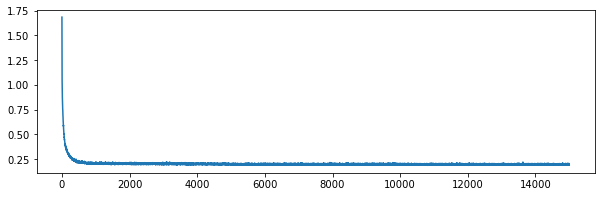

idx 60
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx231/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 3.282136334150477e-05 0.00437266889801548
std_all 0.015282454971375443 0.008637200537492574
mean_all -0.00020368812050494716 0.0026280568211793282
std_all 0.01680007967100222 0.01767186267501537
mean_all -4.6015131273979174e-05 0.0038809122808943844
std_all 0.015788329871251037 0.012423534831658154
[0.19818101 0.31574632 0.38947252 0.45385686 0.51161679 0.55836813
 0.59798679 0.63045651 0.65885388 0.68560734 0.70735994 0.72782679
 0.74638622 0.76389704 0.77975091 0.79484799 0.80919718 0.82210598
 0.83471719 0.84621771]
(81, 81)
[0.22748089 0.39204699 0.51861605 0.60393174 0.66346844 0.71364754
 0.7571015  0.79606208 0.82736225 0.85074716 0.8717038  0.88768618
 0.9026366  0.9137117  0.92415994 0.93376317 0.94202217 0.94910923
 0.95497272 0.96025008]
(64, 81)
[0.19131872 0.32750629 0.41716631 0.47992444 0.53524929 0.58620804
 0.62508253 0.65666438 

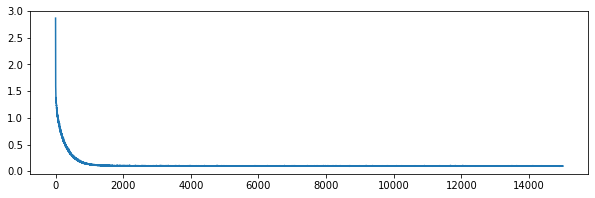

idx 65
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx294/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0002473727177790998 0.009827241754119762
std_all 0.022189440559817673 0.00766040591935582
mean_all 0.0004719190022773506 0.011859989878549929
std_all 0.02754520560960024 0.013104364923892624
mean_all -7.608811093616193e-06 0.01055388777169865
std_all 0.023974695576411863 0.010135923417936146
[0.20350649 0.30765794 0.38247042 0.45238672 0.49591225 0.53666909
 0.57417581 0.60552993 0.62987962 0.65284757 0.67427003 0.69333965
 0.71200644 0.72916865 0.74442569 0.75769013 0.77034765 0.78178869
 0.79243645 0.80271431]
(81, 81)
[0.39091936 0.57320932 0.67031446 0.73701847 0.78070579 0.81215772
 0.83642233 0.85703105 0.87587973 0.89106993 0.90179147 0.91220691
 0.91990478 0.92715564 0.93394195 0.93964195 0.94507401 0.94929097
 0.95311546 0.95643835]
(81, 81)
[0.26096702 0.38478121 0.45983497 0.53091645 0.57343709 0.61112617
 0.64377402 0.672

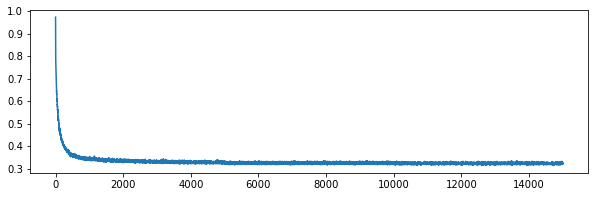

idx 70
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx294/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0008917263134149167 0.007733994158644815
std_all 0.0228414786154507 0.02164067150062147
mean_all -0.00017565958637666136 0.004553011861862273
std_all 0.018877630619591246 0.02503313535410961
mean_all 0.0005359310134843909 0.006858541878049559
std_all 0.021520195950164214 0.02290392920397657
[0.22883793 0.34174051 0.43005234 0.48406459 0.5324579  0.56701908
 0.60081917 0.63073495 0.65840137 0.67993762 0.69799518 0.7152037
 0.73176645 0.74691497 0.76156864 0.77458109 0.78643992 0.79688897
 0.80706088 0.81643772]
(81, 81)
[0.24630459 0.41523224 0.52828947 0.60827034 0.66295003 0.70675279
 0.74178964 0.76835705 0.79245621 0.81374523 0.83282606 0.84740707
 0.86047239 0.87187069 0.88237411 0.89185617 0.89969899 0.90688515
 0.91313864 0.91884737]
(81, 81)
[0.23397255 0.3514654  0.45858868 0.51829719 0.56688781 0.6032779
 0.63607551 0.66415646 0.6910557

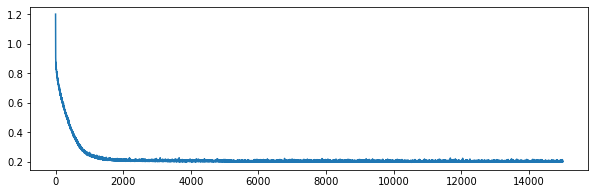

idx 75
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx295/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006056099373938327 0.01171557391466344
std_all 0.027156270599817633 0.008967209310903258
mean_all 0.0007828402145099975 0.012972586545333075
std_all 0.03310916354558015 0.014092580784444716
mean_all -0.00014279322009255594 0.012166655824546622
std_all 0.029140568248405135 0.011299662852881052
[0.1827689  0.27228193 0.34553108 0.41462008 0.46090759 0.503785
 0.54326212 0.57695259 0.60560021 0.6294997  0.6525687  0.67464257
 0.69363369 0.71048642 0.72662066 0.74258718 0.7562443  0.76949384
 0.78192575 0.79330521]
(81, 81)
[0.33789127 0.50504455 0.59933391 0.68500213 0.7368441  0.77865718
 0.81240664 0.84042447 0.86587439 0.88032246 0.89394565 0.90400494
 0.91247775 0.92039894 0.9272091  0.93385064 0.93965059 0.94494955
 0.94910729 0.95280517]
(81, 81)
[0.22891407 0.34032471 0.4160995  0.48645295 0.53177305 0.57221295
 0.60964351 0.6449

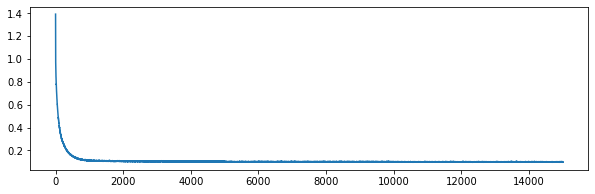

idx 80
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx358/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00039865427885735514 0.00785724504342331
std_all 0.019415554607305627 0.007169552067074435
mean_all 0.0001540860440504138 0.00708359262901482
std_all 0.020647034334363816 0.024885229782424474
mean_all -0.0002144075045547655 0.007612567791086853
std_all 0.019826047849658357 0.015525147806286764
[0.24540236 0.36315188 0.42916002 0.48119455 0.5228071  0.55775498
 0.58527688 0.6105784  0.63512612 0.65626226 0.676797   0.69219818
 0.70682185 0.72129988 0.73407921 0.74598348 0.75725102 0.76816654
 0.77841533 0.78735764]
(81, 81)
[0.30249044 0.42276604 0.49880467 0.57096931 0.61933072 0.6565523
 0.68656464 0.71257827 0.73515663 0.75422897 0.77313344 0.78882633
 0.80392141 0.81797932 0.82906065 0.83946387 0.8483647  0.85681187
 0.86430024 0.87115976]
(81, 81)
[0.25915338 0.36492841 0.44688884 0.50401384 0.54620082 0.58329507
 0.61066583 0.63697032 0.66073

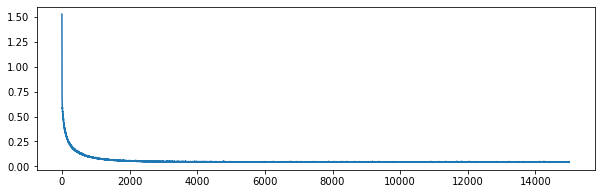

idx 85
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx358/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all 0.0008328141084021917 0.0103500316741782
std_all 0.022471149788364522 0.006958166998670329
mean_all -0.000723368683219288 0.012987628177625063
std_all 0.027144280106013146 0.012506277820087189
mean_all 0.0003140865111950319 0.011321649863776486
std_all 0.024028859894247398 0.009448067271842643
[0.2271362  0.32472812 0.39799285 0.4613476  0.50411457 0.54401501
 0.58030485 0.61098333 0.6361185  0.65895881 0.67886573 0.69775701
 0.71467643 0.73014618 0.74333842 0.75572541 0.76740422 0.7788735
 0.78975996 0.79967503]
(81, 81)
[0.40422768 0.54318916 0.62902294 0.68595872 0.71994487 0.74918278
 0.77471847 0.79917498 0.81629873 0.83193689 0.84474349 0.85593144
 0.86618176 0.87582209 0.88444894 0.89222505 0.89914404 0.90532225
 0.91096575 0.91601111]
(81, 81)
[0.28192443 0.38985201 0.46525143 0.52710456 0.56625737 0.60204556
 0.63512483 0.6

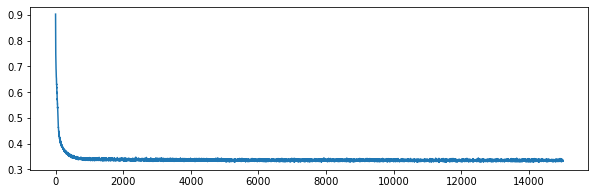

idx 90
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx359/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0005656383213350058 0.016464728986040487
std_all 0.018768809112748887 0.007826465299235327
mean_all -0.0009946361316347748 0.010738070978780588
std_all 0.022210959517183174 0.021148458354337756
mean_all -0.0007086375914349289 0.01480544339379212
std_all 0.01991619258089365 0.01387639893083768
[0.26854788 0.3614106  0.42327011 0.47267338 0.51249456 0.53849568
 0.56286815 0.58331233 0.60333781 0.62108287 0.63805333 0.65244328
 0.66615859 0.67907401 0.69098688 0.70159876 0.71168785 0.7214921
 0.73028161 0.73880986]
(81, 81)
[0.26384446 0.35089239 0.43203324 0.48033248 0.5152479  0.54386048
 0.56815909 0.59042199 0.61061663 0.62772873 0.64284145 0.65747111
 0.67183498 0.68362237 0.69487612 0.70602899 0.71594912 0.72553059
 0.73479807 0.7433231 ]
(81, 81)
[0.25340737 0.35315489 0.41911858 0.46681099 0.50467663 0.53133529
 0.55613676 0.57636341 0.5962640

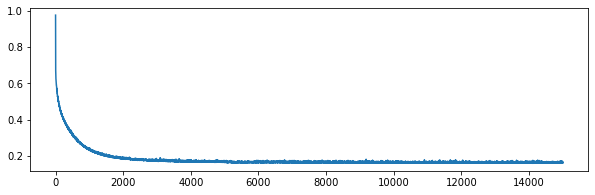

idx 95
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx359/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0005749868846412603 0.013192269765766235
std_all 0.02876778263941482 0.009631344478458443
mean_all -0.00012870561676204157 0.01608815503199556
std_all 0.03334806944019683 0.014836962157948275
mean_all -0.00042622646201485414 0.014224784397417813
std_all 0.030294544906342157 0.011827187001708275
[0.21568547 0.32082025 0.39728104 0.46492764 0.50565643 0.54295441
 0.57826306 0.60988143 0.63681981 0.66012211 0.68123497 0.70152451
 0.71834421 0.73507343 0.75086047 0.76462214 0.77635318 0.7879599
 0.79925052 0.80955684]
(81, 81)
[0.40964444 0.53909113 0.61134939 0.6765205  0.71288092 0.74299767
 0.77051277 0.79396501 0.81029703 0.82582881 0.84103698 0.85329186
 0.8641529  0.87380254 0.8826205  0.89126518 0.89881543 0.90597086
 0.91178563 0.9169938 ]
(81, 81)
[0.27598508 0.38687988 0.45987899 0.52577487 0.56473417 0.59880871
 0.63005042 

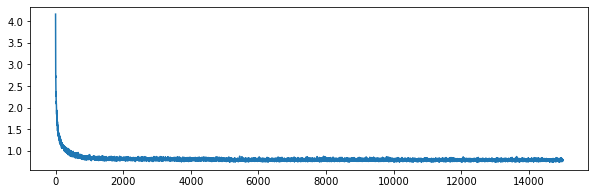

idx 100
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx422/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0002416581928029668 0.00892735239689177
std_all 0.021624315114489083 0.00827930554328939
mean_all -2.6400075818879215e-05 0.00448431537448546
std_all 0.02316223961005553 0.01776785986863251
mean_all 0.00015230543659568478 0.007736326206166942
std_all 0.02213695661301124 0.012306738705626399
[0.2212169  0.31088212 0.39150453 0.45833744 0.51116133 0.55679118
 0.59560778 0.63181309 0.66307118 0.68775146 0.71142    0.73284649
 0.75277293 0.77126717 0.78787437 0.80283672 0.81715236 0.82925505
 0.84123615 0.85261132]
(81, 81)
[0.19473332 0.36906022 0.48581191 0.57887221 0.65615515 0.71925956
 0.76555775 0.80392898 0.83602066 0.86043565 0.87814855 0.89468655
 0.90804247 0.91922161 0.92953653 0.93819682 0.94556298 0.95237498
 0.95806195 0.96307457]
(64, 81)
[0.20126178 0.30937895 0.39069722 0.46188528 0.52434892 0.57366554
 0.61602983 0.65149531 0.681

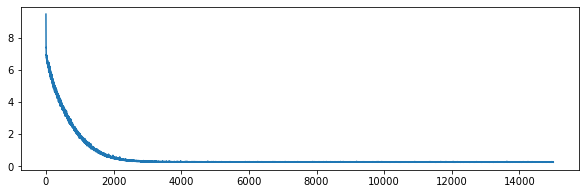

idx 105
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx423/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.002496240381842806 0.01604539437309977
std_all 0.030216853400368466 0.010164029945098144
mean_all 0.0030949773605770036 0.011407651118479566
std_all 0.030034294472430157 0.01075559101029589
mean_all -0.0006325011343695359 0.014898378089722665
std_all 0.03015600042438903 0.01036532626819781
[0.27152644 0.40721531 0.49659198 0.55343212 0.59806037 0.63919533
 0.67329299 0.70568134 0.73295991 0.75873465 0.7788545  0.79725599
 0.81435212 0.82771341 0.83984932 0.85139911 0.86211976 0.87226444
 0.88161954 0.89035123]
(81, 81)
[0.35995662 0.52147213 0.60731167 0.67660734 0.7370589  0.78104887
 0.81680855 0.84936124 0.87314274 0.89478065 0.90988141 0.92123558
 0.93225932 0.94082585 0.94832036 0.95463163 0.96057305 0.9656851
 0.9696894  0.97309673]
(64, 81)
[0.29820348 0.43405497 0.51240829 0.56959443 0.61788765 0.65591911
 0.69022757 0.72196

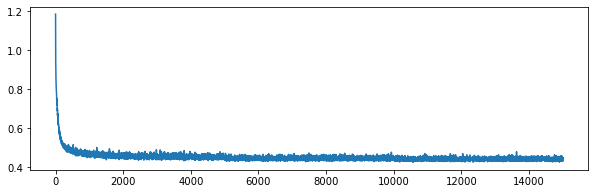

idx 110
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx423/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0015257109167441225 0.017045247755209308
std_all 0.027788657895883154 0.011108014878440662
mean_all 0.0014267944298613064 0.00791172106765567
std_all 0.02703066595737319 0.019980873611325858
mean_all -0.0005415424678756461 0.014713800750087332
std_all 0.02753599391637983 0.014678718539326778
[0.27776916 0.39312443 0.47219698 0.52860999 0.57556177 0.61959231
 0.65444015 0.68429176 0.71173025 0.733824   0.75513565 0.77360136
 0.79018332 0.80571356 0.81853874 0.83059997 0.84127328 0.85168613
 0.86196084 0.87168096]
(81, 81)
[0.28339694 0.41823593 0.55050593 0.62418015 0.68418418 0.73615098
 0.78077635 0.8151722  0.8413091  0.8666007  0.88338465 0.89738293
 0.9102922  0.920664   0.92961404 0.93757483 0.94517902 0.95187163
 0.95743835 0.96232276]
(64, 81)
[0.2713967  0.38705424 0.47132518 0.5314507  0.5767389  0.61985135
 0.65775318 0.68920451 0.71

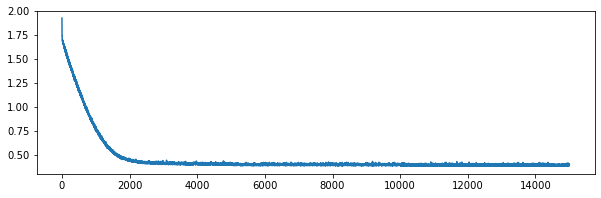

idx 115
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx486/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.002801139523413632 0.016035886654131318
std_all 0.03240402803437928 0.011565188966792116
mean_all 0.0020136489128112435 0.016308441987375594
std_all 0.03986299201592658 0.014083824471190972
mean_all -0.0011962100446720068 0.01628618426166068
std_all 0.034890349361561705 0.012947999406118708
[0.19847996 0.30559797 0.38561528 0.44782647 0.49777139 0.53971571
 0.57206157 0.60215828 0.63063492 0.65565894 0.67834029 0.69965744
 0.720179   0.73782493 0.75289389 0.76769805 0.78081604 0.79358658
 0.80527016 0.81557496]
(81, 81)
[0.32245599 0.48688755 0.57235946 0.64801611 0.70451353 0.74712723
 0.78394119 0.81427019 0.83854202 0.85376574 0.86710787 0.87907901
 0.89058334 0.90078563 0.90875923 0.91668903 0.92334643 0.92964082
 0.93571047 0.94138836]
(81, 81)
[0.23424155 0.35159113 0.42688468 0.48601589 0.53671803 0.57930349
 0.60976829 0.6396

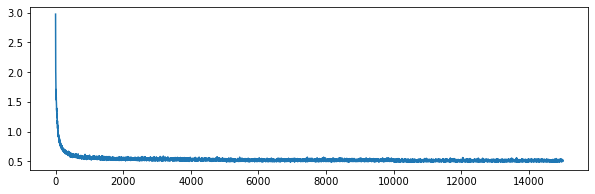

idx 120
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx487/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0009438667584241148 0.012877234889348076
std_all 0.02580080188353929 0.009968487965379311
mean_all 0.000399708527963611 0.007896834005388173
std_all 0.02569343289521696 0.01922515596147818
mean_all -0.0004960083296282063 0.011477656658816192
std_all 0.025765012220765177 0.013764154069838476
[0.23367483 0.33080877 0.41684488 0.46747442 0.51512439 0.55485899
 0.58824543 0.61773965 0.64352424 0.66628092 0.68858514 0.709442
 0.72652828 0.74299167 0.75828165 0.77181133 0.78329135 0.79411093
 0.80434007 0.81402934]
(81, 81)
[0.24729477 0.38438403 0.47791211 0.5496467  0.60923301 0.66463234
 0.71314667 0.75021929 0.77495298 0.79609851 0.8143978  0.83106801
 0.84703027 0.85935095 0.87002351 0.88040087 0.88986196 0.89820363
 0.90580451 0.91268991]
(81, 81)
[0.23514632 0.33984456 0.42377388 0.476355   0.5255439  0.56809153
 0.6043688  0.63722492 0.66144032

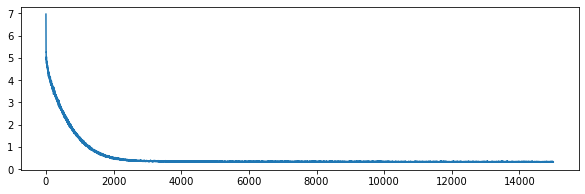

idx 125
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx487/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.001056733900689587 0.015084992326597348
std_all 0.027938407150465482 0.009952571011240934
mean_all 0.0007388567322687691 0.011433664696261243
std_all 0.029970589161696638 0.010007848252996684
mean_all -0.00045820368970346845 0.013999906021759705
std_all 0.028615801154209197 0.01001694467623808
[0.23519247 0.33803683 0.41565738 0.4758148  0.52627431 0.56247768
 0.59719907 0.62765399 0.65457806 0.67820506 0.69975436 0.71980631
 0.73749042 0.75372473 0.76879325 0.78229593 0.79420086 0.80527285
 0.8153601  0.8251425 ]
(81, 81)
[0.3177689  0.46794525 0.54894277 0.61342807 0.6765646  0.72868813
 0.76810823 0.80091502 0.82401862 0.84203738 0.85807805 0.87301803
 0.88485813 0.89531112 0.9048651  0.91279501 0.92010207 0.92724042
 0.93392046 0.93911908]
(81, 81)
[0.25590393 0.36783738 0.43823818 0.49817936 0.54554132 0.58492283
 0.6204065

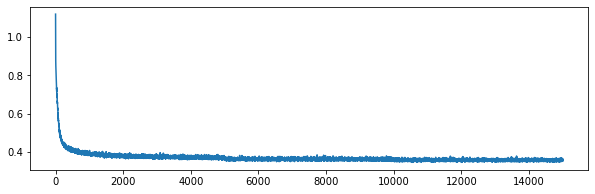

idx 130
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx550/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0006027115964149685 0.012927882240216692
std_all 0.025219425963018304 0.011163337527194629
mean_all -2.3056230252123917e-05 0.011465043972072998
std_all 0.02907686662772497 0.021628873749717132
mean_all -0.0004094931410273537 0.012462363499010424
std_all 0.026505239517920526 0.015566719716124828
[0.20676738 0.30127018 0.38665565 0.44020643 0.48105582 0.51636351
 0.54555398 0.57204894 0.59792884 0.61958005 0.63966266 0.65630472
 0.67240102 0.68732784 0.70165499 0.71378073 0.72508437 0.73570279
 0.74587468 0.75558139]
(81, 81)
[0.27097301 0.39919702 0.48344496 0.5611898  0.61118806 0.64794769
 0.68248667 0.71367426 0.7417161  0.76224537 0.78001272 0.79698266
 0.81170977 0.82539025 0.83568602 0.84580023 0.85539499 0.86394064
 0.87148415 0.87869411]
(81, 81)
[0.22487849 0.32732018 0.40832054 0.46942662 0.51325464 0.54902499
 0.5785343  0.60597587 0.63

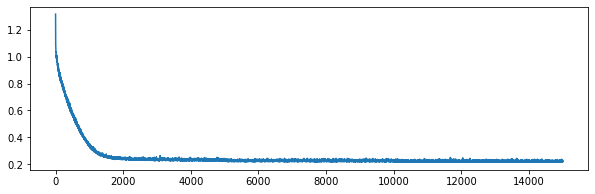

idx 135
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx550/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00043674618477799305 0.01537747326304386
std_all 0.027824141641761765 0.011775123070791914
mean_all 0.0005001229493890648 0.016582100803231296
std_all 0.03461969996638297 0.013884389478147921
mean_all -0.00012445647338897375 0.01579540633794963
std_all 0.030089327749968836 0.012921167729406689
[0.20169571 0.30670215 0.37828965 0.44126404 0.48180303 0.51937277
 0.55408452 0.58506282 0.61295888 0.63558792 0.65682447 0.67642643
 0.69457842 0.71104503 0.72540891 0.73904731 0.75118889 0.76307839
 0.77449483 0.78447786]
(81, 81)
[0.34994776 0.49150301 0.58785429 0.64657369 0.69248793 0.72965678
 0.76239079 0.79065165 0.81696413 0.83276752 0.8470968  0.86030306
 0.87278928 0.8816685  0.89000095 0.89769127 0.90509001 0.9110899
 0.91679991 0.92196056]
(81, 81)
[0.24413846 0.35693442 0.42948558 0.49431167 0.53239691 0.568966
 0.6011804  0.

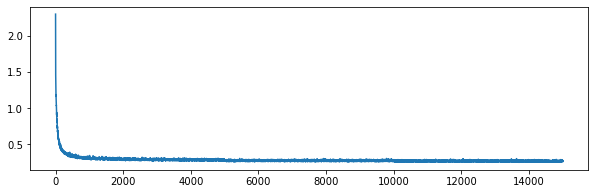

idx 140
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx551/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0003828057564947134 0.010938327975355785
std_all 0.02078815210689663 0.008715197236250706
mean_all 0.000531539010957137 0.009661991409599021
std_all 0.02349432748113199 0.016295389466840348
mean_all -7.802416734409658e-05 0.010538903590895628
std_all 0.021690210564975086 0.011864952596902926
[0.20045209 0.28622777 0.35957437 0.41905568 0.45763855 0.49296426
 0.52257412 0.550314   0.57221495 0.59265447 0.61150289 0.62843458
 0.64419654 0.6591467  0.67268619 0.68573402 0.69736277 0.70863937
 0.71954296 0.72936974]
(81, 81)
[0.31329125 0.41776057 0.49533629 0.56190884 0.61590651 0.64958563
 0.68269408 0.71256995 0.74001183 0.75890109 0.77597148 0.79255083
 0.80752006 0.8220012  0.8334635  0.84414323 0.85325713 0.86186168
 0.86946289 0.87638161]
(81, 81)
[0.23400748 0.31835115 0.39726846 0.45536322 0.49600556 0.53217578
 0.56118222 0.58868573 0.6

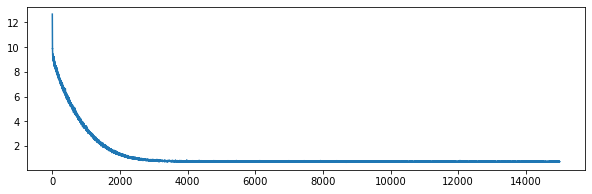

idx 145
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx614/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all 0.00030117988195975235 0.023458091083979102
std_all 0.03275768031331527 0.014615077219000707
mean_all 0.0010339024281131241 0.011721920315992217
std_all 0.029656893740206774 0.011861974502176496
mean_all 0.0005454207306775429 0.020316868295877404
std_all 0.03172408478894577 0.013836152181549275
[0.26978772 0.37279776 0.44917185 0.51080963 0.56340047 0.61181401
 0.64629887 0.67798822 0.70844507 0.73582975 0.75707286 0.77667251
 0.79321542 0.80801807 0.8220391  0.83436392 0.84511734 0.85554227
 0.86528737 0.87484752]
(81, 81)
[0.29848671 0.41917356 0.5221545  0.60202342 0.66588608 0.71164828
 0.75248091 0.78506844 0.8123427  0.8367326  0.86046667 0.87973655
 0.89633717 0.90962734 0.9215153  0.93173184 0.94042477 0.94806842
 0.95424727 0.95973489]
(64, 81)
[0.26777724 0.36386362 0.43641298 0.49687667 0.54894631 0.59611817
 0.63785589 0.67

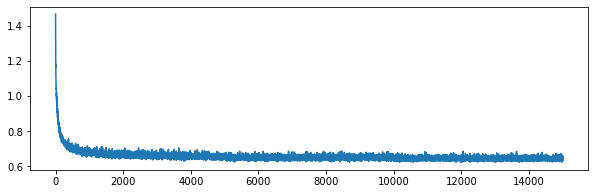

idx 150
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx614/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 7.091166055478784e-05 0.01805282892921564
std_all 0.025354991723633764 0.010102338617140702
mean_all 0.0003280861684278408 0.006570475230280718
std_all 0.025368548992857513 0.021249345473285275
mean_all 0.000156636496512472 0.01522086837132694
std_all 0.02535951081337502 0.01478342874805894
[0.24582649 0.3540585  0.43761127 0.49944674 0.54543621 0.58880208
 0.6230782  0.65515116 0.68413632 0.70703373 0.72860376 0.74969967
 0.76879776 0.78647556 0.80201329 0.81628641 0.829412   0.84168928
 0.8521796  0.86172253]
(81, 81)
[0.21228003 0.39189679 0.49197875 0.57637357 0.64364938 0.69516227
 0.74289957 0.77784033 0.80515816 0.82743434 0.84739698 0.86691307
 0.88343262 0.89754269 0.90961913 0.92134983 0.93122056 0.94013836
 0.94711017 0.95347116]
(64, 81)
[0.22745309 0.3274532  0.42004106 0.48592956 0.53714186 0.58211395
 0.61781992 0.649867   0.680263

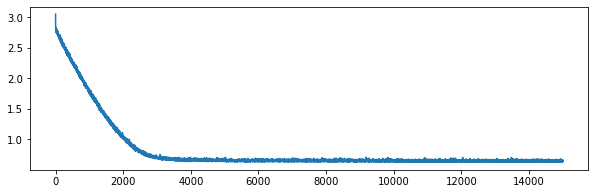

idx 155
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx615/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0012845236961087413 0.022911100910374772
std_all 0.041428820848816356 0.01632677123271808
mean_all 0.0016929725939591994 0.014197834819073262
std_all 0.038578079832115586 0.017509552963148958
mean_all -0.0002920249327527616 0.020472143074366685
std_all 0.04047857384324943 0.01678421062556387
[0.26577672 0.38977414 0.47814782 0.55283726 0.60998693 0.65682551
 0.69198565 0.72170478 0.74369145 0.76488605 0.78328431 0.80020919
 0.81703595 0.83224932 0.84542636 0.85706017 0.86807864 0.87717281
 0.88621192 0.8943237 ]
(81, 81)
[0.28232252 0.42687727 0.52104035 0.60815425 0.66922206 0.72076072
 0.77023557 0.8079579  0.83270373 0.85564022 0.87270496 0.88746151
 0.90196232 0.91521283 0.92684915 0.93748998 0.94599306 0.95203967
 0.95776852 0.96262208]
(64, 81)
[0.25700295 0.37046361 0.45583348 0.52276459 0.58709064 0.63216794
 0.6702408  0.703

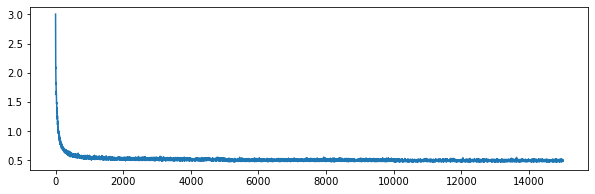

idx 160
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx678/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 5.320676785313891e-06 0.013493499443583728
std_all 0.025524430211628292 0.00995796629987019
mean_all 0.0002343237436873291 0.008338852898142025
std_all 0.026517322154590864 0.018899347822746354
mean_all 8.16550324193189e-05 0.012023871862922536
std_all 0.025855394192615816 0.013615735464578164
[0.22999314 0.32409929 0.4158607  0.47619912 0.52894334 0.5676469
 0.60041512 0.63004941 0.6555835  0.67993133 0.69881358 0.71671028
 0.73347364 0.74976572 0.76341721 0.77633297 0.78738436 0.79841884
 0.80876716 0.81825769]
(81, 81)
[0.25608952 0.3751811  0.48660812 0.56922151 0.63284478 0.68312665
 0.72830732 0.76445892 0.79372314 0.8172435  0.83411926 0.84947673
 0.8631507  0.87501663 0.88646469 0.89555131 0.90422371 0.91203858
 0.91844983 0.92446322]
(81, 81)
[0.23424048 0.3299125  0.42435223 0.4886561  0.54490503 0.58470512
 0.62041338 0.64984584 0.6743464

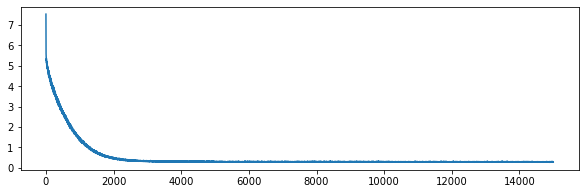

idx 165
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx678/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0001321849343911142 0.014242698619314712
std_all 0.026723598035480793 0.009692196762722288
mean_all 0.00039097687547249736 0.01250465364114872
std_all 0.03134938650842896 0.010810811539659407
mean_all 4.2202335563422976e-05 0.013690115121574465
std_all 0.028265527526463514 0.010312068684340293
[0.220974   0.32094773 0.39616119 0.46299502 0.51406177 0.55883335
 0.59448078 0.62369246 0.65032191 0.67377589 0.69509066 0.71307467
 0.73037163 0.74651966 0.76091913 0.77413371 0.7867418  0.79906352
 0.81083478 0.82144121]
(81, 81)
[0.34742317 0.46567668 0.55164023 0.6300308  0.69356536 0.73918155
 0.78389647 0.81774306 0.84570631 0.8656731  0.88181818 0.89481357
 0.90491329 0.91416427 0.92194292 0.92939458 0.93612108 0.9416328
 0.9465015  0.95081305]
(81, 81)
[0.25154679 0.35090506 0.42302922 0.49040788 0.54582256 0.58811284
 0.62719924

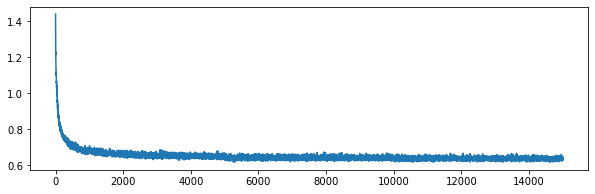

idx 170
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx679/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0001332895752506676 0.013666891576174815
std_all 0.02778214588833597 0.010813963569681057
mean_all 0.0006649012704258521 0.007874908177061128
std_all 0.026490499344165135 0.02031536231992729
mean_all 0.0003104934736423957 0.0120522534108303
std_all 0.027351597040279025 0.01469364711052681
[0.2218681  0.31671091 0.39195896 0.44408529 0.49076347 0.53001947
 0.56316985 0.59302838 0.61981981 0.64210169 0.6628245  0.68245006
 0.70039445 0.71524868 0.72943606 0.74262303 0.75526269 0.76758537
 0.77949862 0.79120668]
(81, 81)
[0.23700766 0.36566401 0.46570477 0.55284064 0.61320063 0.66382007
 0.70363418 0.73899891 0.7722887  0.79640244 0.81478748 0.83210967
 0.84721121 0.86017116 0.87196275 0.8826907  0.89182434 0.90039339
 0.90818122 0.91527329]
(81, 81)
[0.2217031  0.32382185 0.40148121 0.46345551 0.51205317 0.55320548
 0.5865808  0.61724075 0.64432388 0

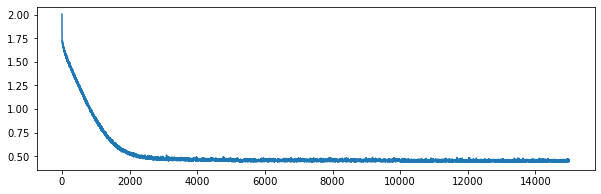

idx 175
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx679/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00029183739244182717 0.01623864890765727
std_all 0.0343500887962632 0.011985075349409015
mean_all 0.0006594819601560568 0.01270422766478889
std_all 0.03437102362229775 0.012793824025705034
mean_all 2.526905842413411e-05 0.015159025653145714
std_all 0.03435706707160805 0.012260591171727018
[0.21025428 0.31757161 0.39291477 0.45222664 0.50004124 0.5380933
 0.57146216 0.60353806 0.63309515 0.65851228 0.67966704 0.70004411
 0.7199793  0.73581082 0.75051727 0.76449583 0.77834695 0.79060872
 0.80252744 0.81400768]
(81, 81)
[0.2942236  0.43441982 0.52780337 0.59903782 0.6614284  0.71207768
 0.754517   0.7870709  0.81696728 0.84215158 0.85780758 0.87297132
 0.88595892 0.89750241 0.90736843 0.91565235 0.92324648 0.92991849
 0.93562251 0.9409633 ]
(81, 81)
[0.2313439  0.34323895 0.41268466 0.47853054 0.52960666 0.56814781
 0.60101516 0.632

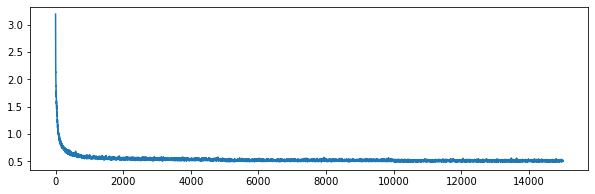

idx 180
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx742/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00034645448336852094 0.012689297929412969
std_all 0.022961963582569557 0.010280854718843886
mean_all 0.0005143605462861995 0.007814574958637882
std_all 0.02336291194139243 0.01929069938155222
mean_all -5.951614015028072e-05 0.01130778710069351
std_all 0.023095613035510512 0.013947881597659634
[0.20782282 0.29842135 0.36906163 0.41784113 0.46215266 0.49527448
 0.52725679 0.55834928 0.58131521 0.60306624 0.62365661 0.64173591
 0.6587948  0.674018   0.68775752 0.70044142 0.71265461 0.72425019
 0.73468777 0.74471822]
(81, 81)
[0.24646055 0.3633875  0.44482933 0.52149376 0.57704443 0.62051543
 0.6622216  0.70040222 0.73439187 0.75565423 0.77492327 0.79240201
 0.80907388 0.82298814 0.83353023 0.84369642 0.85351621 0.86276008
 0.87113559 0.87886659]
(81, 81)
[0.21707654 0.3067973  0.38559161 0.44257945 0.4862392  0.52169516
 0.55333328 0.58374926 0.

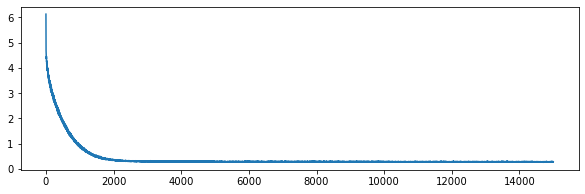

idx 185
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx743/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.000969113675307457 0.012104555774260528
std_all 0.024841059540681613 0.00892081296283686
mean_all 0.001214914424818506 0.014069148896538503
std_all 0.029954624795366043 0.011827805828890892
mean_all -0.00024110430859880275 0.01283434815232717
std_all 0.026545581292243086 0.01027117593026003
[0.19102445 0.27691482 0.34608171 0.40177987 0.44744071 0.48411195
 0.51842556 0.55026911 0.58103218 0.60561132 0.62623754 0.64653081
 0.66652707 0.68414689 0.69989391 0.71467014 0.72843865 0.74078652
 0.75229269 0.76362179]
(81, 81)
[0.34249344 0.47846726 0.56084693 0.62564167 0.68062802 0.71844977
 0.75336187 0.78347722 0.81014506 0.82774164 0.84302035 0.85755892
 0.86940057 0.87927791 0.88815994 0.89598738 0.90330254 0.9097929
 0.91566652 0.92087194]
(81, 81)
[0.23441522 0.33209227 0.39955496 0.45890756 0.49897986 0.53687614
 0.56950089 0.6002

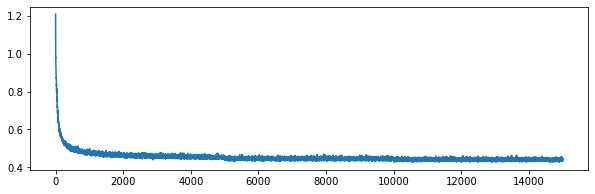

idx 190
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx743/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0007674587591319176 0.010733118295603052
std_all 0.02378890857708709 0.009867597337941934
mean_all 0.0005745754830658466 0.010467403009552683
std_all 0.025797385238618232 0.020078491596620146
mean_all -0.00032011401173266294 0.010664065616161044
std_all 0.02445840079759747 0.01414889981874924
[0.18970216 0.26874702 0.34234297 0.39459324 0.4421055  0.47850403
 0.51175007 0.54070333 0.56702035 0.58824899 0.60774732 0.62610616
 0.6441659  0.66067657 0.67496107 0.68873779 0.70159921 0.71320887
 0.72458673 0.73558081]
(81, 81)
[0.28465791 0.40983176 0.49167862 0.56623099 0.62003095 0.6576367
 0.69157989 0.72442637 0.74997841 0.77090906 0.78786609 0.80370371
 0.8179189  0.83122748 0.84196364 0.85201693 0.86120107 0.86927212
 0.87641484 0.88310155]
(81, 81)
[0.21753909 0.30929595 0.38356152 0.44087907 0.47965289 0.51654874
 0.55117914 0.57988836 0.60

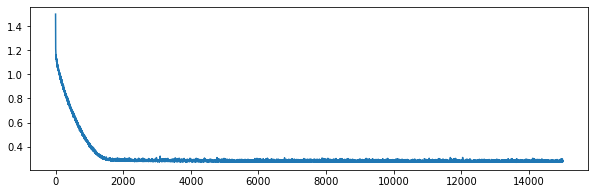

idx 195
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx806/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0017935768750100842 0.010844761066488746
std_all 0.028576078698531116 0.008927848084332658
mean_all 0.0014464991011534799 0.009276471042258585
std_all 0.036553079070280194 0.014957825207568947
mean_all -0.0007135515496222294 0.010460550151198187
std_all 0.03123507882244747 0.011910375976824478
[0.19035892 0.29258403 0.37406681 0.43220968 0.48685658 0.53054284
 0.56859791 0.60369163 0.63421205 0.65954384 0.68472419 0.70603334
 0.72664561 0.74573625 0.7634462  0.77997132 0.79512101 0.80947964
 0.82326561 0.83594642]
(81, 81)
[0.26222337 0.43119464 0.59319669 0.71527607 0.78733163 0.85514336
 0.87701324 0.89563427 0.9121413  0.92559219 0.93672479 0.9461335
 0.95337752 0.95866674 0.96357754 0.9676703  0.97133985 0.97462473
 0.9774533  0.979975  ]
(64, 81)
[0.19781438 0.32426261 0.43064256 0.50592213 0.55923271 0.60014175
 0.63797419 0.66

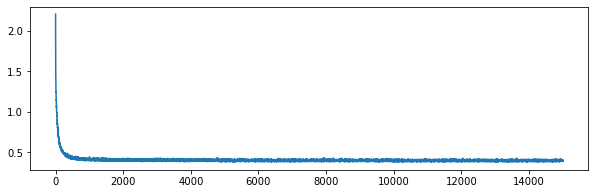

idx 200
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx807/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0006835975439645531 0.008298985013305001
std_all 0.024605724642385942 0.019236094739779833
mean_all -0.000240369237207672 0.0038229294494094186
std_all 0.02318816153387491 0.021591925443947942
mean_all 0.0003756086169071448 0.007139800117473496
std_all 0.024133203606215597 0.02006327974875426
[0.17705973 0.28594154 0.36290817 0.42989451 0.48827118 0.53947569
 0.58239333 0.61673748 0.64516629 0.6714208  0.69556548 0.71865923
 0.73877007 0.75832762 0.77446979 0.79017742 0.80541139 0.81942722
 0.832055   0.84359656]
(81, 81)
[0.19153318 0.3272223  0.45001885 0.56019098 0.6408197  0.70426985
 0.75196058 0.78517202 0.8103662  0.83529908 0.85622061 0.87420396
 0.89008014 0.9039182  0.91535243 0.924901   0.93371808 0.94124627
 0.9480053  0.95371469]
(64, 81)
[0.16000541 0.27276156 0.3753802  0.44982072 0.50948452 0.5607472
 0.60317696 0.63533203 0.666235

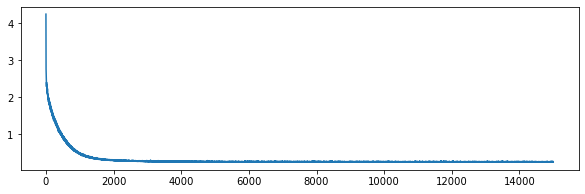

idx 205
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx807/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0015195353125638388 0.008380745683335224
std_all 0.027826514230481707 0.008988762197299162
mean_all 0.0004460808977312502 0.0076799951852995285
std_all 0.02964826978082928 0.009916944942770371
mean_all -0.0008643299091321426 0.008206336722066764
std_all 0.02843376608059757 0.009347976920773509
[0.16765143 0.27463754 0.35793505 0.42473733 0.48192436 0.53276285
 0.57465605 0.61008834 0.63947504 0.66597197 0.6913813  0.71518344
 0.73387466 0.75194572 0.7689145  0.78375093 0.79848075 0.81180789
 0.82376212 0.83518577]
(81, 81)
[0.22896355 0.41540193 0.54957745 0.63995632 0.71408143 0.76674935
 0.80948858 0.84135398 0.86322594 0.88251923 0.89792335 0.90987891
 0.91988954 0.92957827 0.93776599 0.94481913 0.95173298 0.95680505
 0.9614898  0.96583414]
(64, 81)
[0.18127248 0.301351   0.39948099 0.47477877 0.52966285 0.58126528
 0.6225786

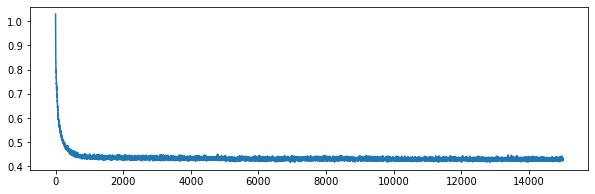

idx 210
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx870/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.000783470807171449 0.010506703337247944
std_all 0.026955041061403513 0.008915016948766607
mean_all -0.00030609932935373764 0.008558445081490278
std_all 0.029639996059495074 0.02350933410901953
mean_all -0.000624346981232212 0.009902533928220065
std_all 0.027850026060767363 0.015453692477178592
[0.18084664 0.28271397 0.37162772 0.44341146 0.50101678 0.54348877
 0.58085831 0.61493162 0.64345502 0.6661124  0.68700108 0.70622204
 0.72358673 0.73926028 0.7535501  0.76689815 0.77922719 0.7908851
 0.80184647 0.81184176]
(81, 81)
[0.27857396 0.44608682 0.57278087 0.65678856 0.71405761 0.75454696
 0.78917624 0.81580859 0.83478798 0.8510048  0.86660501 0.87950095
 0.89079119 0.90196126 0.9097815  0.91721107 0.92385918 0.9298817
 0.93537937 0.94006008]
(81, 81)
[0.20666631 0.32095809 0.41760374 0.49108417 0.54500118 0.58500179
 0.62022836 0.65355559 0.680308

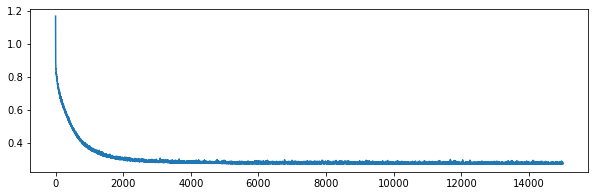

idx 215
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx870/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006442883687931741 0.012374788409275672
std_all 0.03173790806026597 0.00818374044270968
mean_all -2.3880794428081013e-05 0.012177357931273568
std_all 0.033559172568365936 0.012725092521094014
mean_all -0.0004374858440048097 0.012312803989351782
std_all 0.032344996229632626 0.00996805783841561
[0.18367936 0.28593149 0.36851901 0.43210114 0.48608863 0.53038223
 0.57280034 0.60660885 0.63755871 0.6615265  0.68444058 0.70346116
 0.72153783 0.73734073 0.75241721 0.76668169 0.77975805 0.79199664
 0.80381215 0.81504477]
(81, 81)
[0.33556669 0.51326233 0.62329349 0.70387597 0.75248228 0.7870551
 0.81987958 0.8445522  0.86357035 0.87771353 0.89078126 0.9030724
 0.91226094 0.92038461 0.92758492 0.93409204 0.93981793 0.94530092
 0.95004666 0.95466898]
(81, 81)
[0.22435641 0.34934388 0.43472866 0.50629435 0.55658577 0.59694004
 0.63561043 0

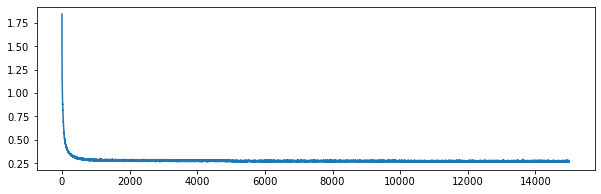

idx 220
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx871/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 4.0923798096769825e-06 0.006590983485663246
std_all 0.01847326919286776 0.007665769465022651
mean_all -0.00026192077588421545 0.004504761010731218
std_all 0.018113782843280572 0.021323784025848745
mean_all -8.457867208828723e-05 0.005978354670895205
std_all 0.01835344040967203 0.013812047419873257
[0.19980467 0.29708843 0.37894959 0.42997494 0.47648862 0.51544224
 0.55232474 0.5852612  0.60909438 0.63285648 0.65469107 0.67518202
 0.69490814 0.71346777 0.72998483 0.74615171 0.76017113 0.77326039
 0.784904   0.79584661]
(81, 81)
[0.2690502  0.42160024 0.53382394 0.62321707 0.6761296  0.71590202
 0.74886301 0.77793555 0.80267581 0.82059163 0.83709756 0.85190009
 0.86388009 0.87473987 0.88413447 0.89305918 0.90130314 0.90871235
 0.9149131  0.92061012]
(81, 81)
[0.22078994 0.33157917 0.42287387 0.48517041 0.53017347 0.56812735
 0.60252644 0.63426181 

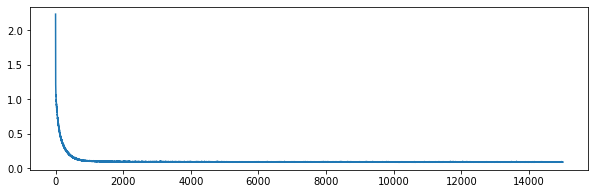

idx 225
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx934/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0008430267350469142 0.011037644223670541
std_all 0.023658240827706165 0.007943318929098485
mean_all 0.00036749486427885313 0.013186054142877206
std_all 0.029221319304664956 0.012604773283092702
mean_all -0.0004395195352716584 0.011811126283257483
std_all 0.025512600320025763 0.010094632823064128
[0.20462917 0.30599388 0.36994945 0.43085776 0.4729469  0.51109904
 0.54677053 0.58058076 0.60392672 0.62612737 0.64786568 0.66701351
 0.68461656 0.70185753 0.71757823 0.73225558 0.7444402  0.75572889
 0.76692616 0.77783375]
(81, 81)
[0.39305511 0.56425787 0.64789799 0.72096474 0.75721937 0.78828406
 0.81386639 0.83791894 0.85166654 0.8637905  0.87486068 0.88444696
 0.8937541  0.90235885 0.91021509 0.91762526 0.9232423  0.92821232
 0.93295871 0.93721598]
(81, 81)
[0.26244337 0.38345201 0.45008733 0.51294595 0.55373308 0.58821551
 0.62094032 

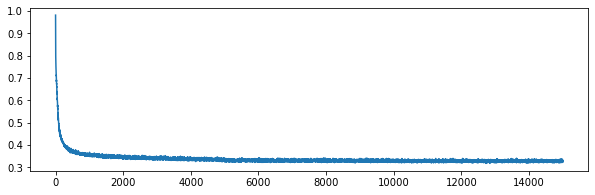

idx 230
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx934/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0007968344697572946 0.009576670646191672
std_all 0.021235883189486954 0.011804690464152492
mean_all 0.00013170666101774197 0.010156999681041572
std_all 0.02328156348096895 0.028499846292524382
mean_all -0.0004873207594989491 0.0097837395078597
std_all 0.021917776619980955 0.019093913031031
[0.22487674 0.3209847  0.40340033 0.45332835 0.49436927 0.52940832
 0.56102103 0.58840877 0.61380681 0.63497633 0.65455588 0.67215144
 0.68887449 0.70454159 0.71836778 0.73101047 0.74249982 0.75315057
 0.76310473 0.77250081]
(81, 81)
[0.30262416 0.44706768 0.53296998 0.60479959 0.64800637 0.6875527
 0.71985937 0.74678148 0.76951791 0.78724866 0.80246689 0.81652821
 0.82960571 0.84143254 0.85173542 0.86128492 0.86969005 0.87714767
 0.88426105 0.8903994 ]
(81, 81)
[0.24746889 0.35200749 0.44017596 0.49538587 0.53632127 0.57304852
 0.60293573 0.63088867 0.65365

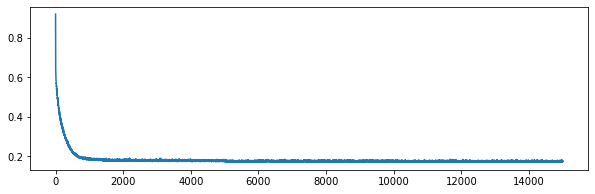

idx 235
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx935/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006905464173857768 0.01323066182379614
std_all 0.02677301622002605 0.008824394919620535
mean_all -8.034845113489327e-05 0.014663118098528893
std_all 0.0328786239047095 0.013395999663969857
mean_all -0.000487147095302149 0.013727783077492438
std_all 0.028808218781587198 0.010955135708750795
[0.20959562 0.29948592 0.37291    0.43255947 0.47285091 0.51143432
 0.5478855  0.5815626  0.60854098 0.63470708 0.65720596 0.67792256
 0.6973294  0.71461635 0.72960425 0.74369317 0.7565124  0.76886608
 0.7805026  0.79175412]
(81, 81)
[0.37605562 0.53743826 0.63102189 0.70062505 0.73760098 0.76875362
 0.79670539 0.82076366 0.83674282 0.85069626 0.86357626 0.87383652
 0.88337284 0.892136   0.89973366 0.90709439 0.91314448 0.91890558
 0.92376675 0.92845661]
(81, 81)
[0.25790594 0.36789151 0.44408738 0.50679156 0.54509494 0.58120868
 0.61426216 0.6465

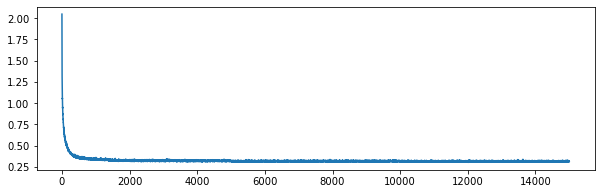

idx 240
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx998/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0014017453667654355 0.009324860007324616
std_all 0.02656275936871376 0.024669118164085926
mean_all -0.00011717625846665837 0.0046160433408693816
std_all 0.022272738455169912 0.019865950744583617
mean_all -0.0009735556639991766 0.008089374985467438
std_all 0.025132752397532477 0.02326697445306869
[0.19581132 0.28866525 0.36987243 0.43878445 0.49288704 0.5420465
 0.57906545 0.61171872 0.64078201 0.6690223  0.69453262 0.71650349
 0.7363651  0.75528981 0.77309625 0.78932007 0.80509468 0.81939122
 0.83235722 0.84426763]
(81, 81)
[0.18494862 0.35267525 0.48457645 0.5765707  0.66048877 0.72851469
 0.77290983 0.81147496 0.84007651 0.86245334 0.8805749  0.89675672
 0.91150481 0.92321628 0.93155836 0.9387252  0.94551729 0.95188013
 0.95733711 0.96196246]
(64, 81)
[0.18156477 0.29453219 0.39553122 0.46191392 0.51990819 0.57063297
 0.60725428 0.64098583 0.67

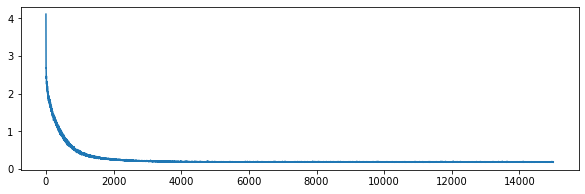

idx 245
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx998/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006403429313714246 0.009898720316279822
std_all 0.02601149294743061 0.010938685706664142
mean_all -0.00011272936130351735 0.008835450242397073
std_all 0.028454135649043838 0.01179042155057135
mean_all -0.0004644717413487888 0.009560684997052881
std_all 0.02682570718130169 0.011288658013397986
[0.18501337 0.2912085  0.37303181 0.44743446 0.5005874  0.54887587
 0.59056823 0.62471811 0.65467935 0.6815107  0.70635114 0.72804193
 0.74890067 0.76764523 0.78435121 0.79923912 0.81316788 0.82596083
 0.83785811 0.84759142]
(81, 81)
[0.28621133 0.46213417 0.60140818 0.69201986 0.77449375 0.82934998
 0.8591158  0.88139085 0.89751711 0.91178369 0.9243968  0.93474941
 0.94281118 0.94978004 0.95571274 0.96077445 0.96557215 0.96974769
 0.97362817 0.97675869]
(64, 81)
[0.21170872 0.33471213 0.42914438 0.50172887 0.55877398 0.60600015
 0.6432437

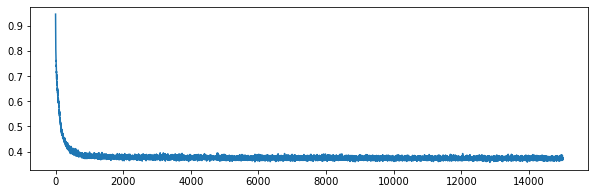

idx 250
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx999/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.00025411086440508396 0.006586008397631692
std_all 0.018336860490243308 0.00823380540461727
mean_all -0.0002261930540484777 0.004173402043054712
std_all 0.022997952201153263 0.026216179982341426
mean_all -0.00024480492761954844 0.005892617342717363
std_all 0.019890557727213293 0.016706915198740683
[0.17924769 0.28744645 0.36953969 0.43354122 0.49031157 0.54207526
 0.59113348 0.62507012 0.65540931 0.68166317 0.70632823 0.72691727
 0.74713567 0.76476687 0.78090823 0.79489513 0.80749585 0.8189668
 0.83010921 0.84069835]
(81, 81)
[0.18546118 0.36047837 0.51039992 0.60046101 0.65683002 0.7069099
 0.74316316 0.77422072 0.80382915 0.82753873 0.84604692 0.86310862
 0.87776735 0.89226866 0.90509016 0.91453335 0.92294151 0.93113573
 0.93881656 0.94553181]
(64, 81)
[0.17652024 0.28954836 0.39260002 0.46876612 0.52251008 0.57046676
 0.613923   0.6461486  0.674

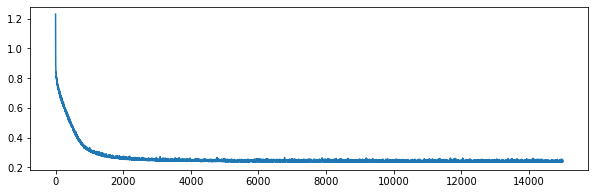

idx 255
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx999/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0012736348639408037 0.011706390397200013
std_all 0.03457559368148852 0.013138418275951325
mean_all -0.0004009141806114523 0.009616039843130647
std_all 0.03045734763448185 0.012158179082925285
mean_all -0.0009827279694976869 0.011061270804860785
std_all 0.033202844999152964 0.012966161368080502
[0.23433823 0.35434438 0.43549993 0.50153562 0.56379742 0.61640055
 0.65415733 0.68786953 0.71994709 0.74755817 0.77013674 0.79022801
 0.80718546 0.82227603 0.83605421 0.84769675 0.85881527 0.86949879
 0.87973814 0.88859393]
(81, 81)
[0.2824684  0.46375403 0.59706659 0.68905488 0.75366504 0.79731064
 0.83027041 0.85831137 0.87999728 0.90023174 0.91447275 0.92750507
 0.93661504 0.94401709 0.95123437 0.95741902 0.9624365  0.96716046
 0.97082209 0.97373029]
(64, 81)
[0.23938201 0.3761908  0.46495104 0.54115526 0.60169268 0.64972799
 0.68676569

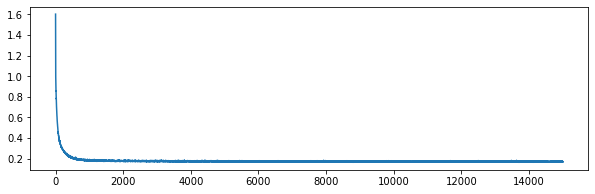

idx 260
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1062/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00023324736012679417 0.006597078629156407
std_all 0.017412692940430505 0.006245999301430748
mean_all 0.00014849685021074547 0.004449682902229115
std_all 0.01755270865780106 0.02196587542678488
mean_all -0.00010599929001428093 0.005970475225000062
std_all 0.01745936484622069 0.013669159537839419
[0.22296283 0.33700088 0.43385729 0.48906441 0.53743846 0.57493692
 0.60911617 0.64111634 0.66621578 0.68941263 0.70875625 0.72740267
 0.7450935  0.76147407 0.77418431 0.78676621 0.79840551 0.80873917
 0.81883273 0.82801337]
(81, 81)
[0.29132453 0.44672307 0.56063843 0.63924341 0.68627257 0.72759592
 0.75988455 0.7866496  0.81055717 0.8278761  0.84371577 0.85811665
 0.87065277 0.88103622 0.89024024 0.89878668 0.90565205 0.91172821
 0.91753591 0.92313915]
(81, 81)
[0.24216415 0.36796831 0.46982299 0.53021864 0.57703596 0.61142704
 0.64509337 0.67536787

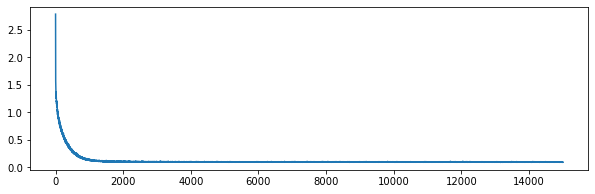

idx 265
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1063/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006894539541627553 0.01284208573718304
std_all 0.02383370301555476 0.006960857715482406
mean_all 0.001234303820918189 0.011998192884490973
std_all 0.027831078505744986 0.012857817928560656
mean_all -4.820136246910721e-05 0.012599764468352743
std_all 0.025166161512284835 0.009537351764290524
[0.23097167 0.33161335 0.40849428 0.47586627 0.52198108 0.56143742
 0.59416394 0.62510938 0.65393523 0.67651282 0.69841332 0.71738301
 0.7355534  0.75130762 0.76658981 0.78023862 0.79153592 0.80256261
 0.81308348 0.8230022 ]
(81, 81)
[0.36687886 0.54042083 0.63667761 0.71716105 0.76023471 0.79683374
 0.82445531 0.8488261  0.86983473 0.88211159 0.89344434 0.90265766
 0.91180493 0.91953003 0.92647146 0.93308964 0.93869764 0.94330295
 0.94776638 0.95169953]
(81, 81)
[0.2650941  0.38362307 0.46466771 0.5331876  0.5779747  0.61493738
 0.64829361 0.6

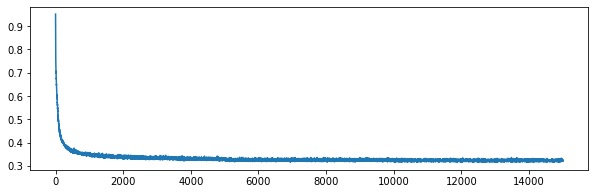

idx 270
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1063/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 6.334877418072508e-06 0.0072153274380196385
std_all 0.019553006156231123 0.014888848455569191
mean_all 0.00012812383981403093 0.004110070031392449
std_all 0.017182008304794254 0.021017659445640203
mean_all 4.6931198216725336e-05 0.006351494944924456
std_all 0.018762673539085502 0.017212838029729095
[0.21590481 0.31002173 0.39257745 0.45335898 0.49915682 0.54130463
 0.57467068 0.60258144 0.62914376 0.65394689 0.67518081 0.69536846
 0.71230346 0.72834565 0.74246749 0.75603839 0.76870788 0.78051657
 0.79177472 0.80207081]
(81, 81)
[0.22674975 0.36593697 0.47698013 0.56375985 0.62528746 0.66989063
 0.7072342  0.73988903 0.76500508 0.78749471 0.80472037 0.82079737
 0.8347841  0.84793507 0.85801722 0.86749814 0.87637935 0.88475898
 0.89222017 0.89924367]
(81, 81)
[0.21757185 0.32401542 0.41466566 0.48067482 0.526859   0.57108132
 0.60153287 0.63031133

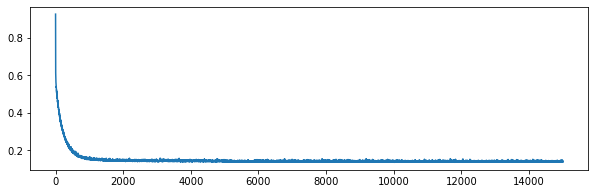

idx 275
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1126/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.000514734742291956 0.011161541869057469
std_all 0.025255337251424266 0.008324538088256865
mean_all 0.0007165916924470328 0.014384077110314392
std_all 0.03245761310227477 0.01430307888208653
mean_all -0.00010429259737895964 0.012343317822892958
std_all 0.02765609586837443 0.011221345520837077
[0.194348   0.28651065 0.3612132  0.42608797 0.46815209 0.50871395
 0.54654577 0.582689   0.60859267 0.63284771 0.65330481 0.6727961
 0.69153456 0.70817178 0.72296803 0.73582999 0.74787886 0.75987442
 0.77153346 0.78261437]
(81, 81)
[0.39921326 0.55674386 0.6409763  0.70048245 0.73454704 0.7669494
 0.79544368 0.82010106 0.83628087 0.85054847 0.86392396 0.8753799
 0.88397721 0.89221106 0.90019915 0.90667731 0.91272781 0.91870515
 0.92354129 0.92811918]
(81, 81)
[0.25888828 0.36828259 0.44080361 0.50770062 0.54722403 0.58320737
 0.61752723 0.65026

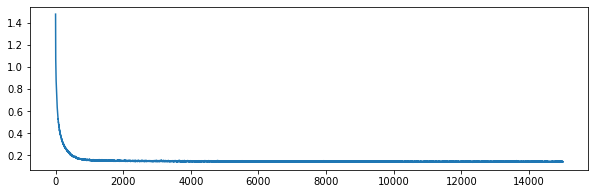

idx 280
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1127/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -7.347248740273179e-05 0.009135650699179978
std_all 0.019966246750063796 0.007525842399582807
mean_all -1.734301297842694e-05 0.008012826601741137
std_all 0.022487785502906026 0.024689744366612913
mean_all -5.476266259463016e-05 0.008777389852906003
std_all 0.020806759667677876 0.015568117594659795
[0.23714987 0.3402849  0.41609137 0.46819418 0.51053885 0.54352024
 0.57278285 0.59856136 0.621828   0.64284679 0.66208296 0.68022888
 0.69698736 0.71145683 0.72588483 0.73769578 0.74887354 0.75916604
 0.76879689 0.77777423]
(81, 81)
[0.29396501 0.40745749 0.50027973 0.56845639 0.61610291 0.65757569
 0.68972803 0.71862493 0.74238869 0.76084385 0.77882227 0.79518332
 0.80882448 0.82095707 0.8315273  0.84176765 0.85147404 0.85949322
 0.8671239  0.8741675 ]
(81, 81)
[0.25209289 0.35024294 0.43561214 0.49075654 0.53503468 0.5706758
 0.60086464 0.6278185  0.6

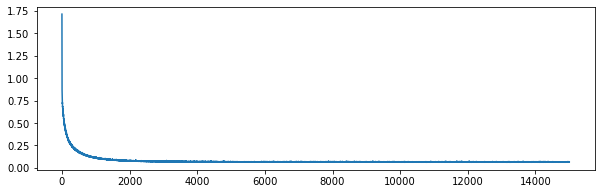

idx 285
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1127/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all 8.999815931812492e-05 0.011633891542260294
std_all 0.02217446748807303 0.007496412854724719
mean_all -0.00017703549149039483 0.013639509707044098
std_all 0.027982873771994828 0.012529918058550553
mean_all 9.869423819515927e-07 0.012339349359712936
std_all 0.02411060291604696 0.009863788661964362
[0.22411209 0.32235341 0.40129966 0.46134049 0.50060118 0.53809468
 0.57222146 0.60444865 0.62755367 0.64819317 0.66837546 0.68681679
 0.70436707 0.72009274 0.73447601 0.7463464  0.75749851 0.76821956
 0.77776492 0.78682208]
(81, 81)
[0.39676124 0.53840037 0.62079162 0.69343946 0.73202473 0.76340807
 0.79040819 0.81356333 0.8282135  0.84234862 0.85407426 0.86496062
 0.87481081 0.88357656 0.89096111 0.89822323 0.9045556  0.91052538
 0.91590388 0.9209696 ]
(81, 81)
[0.27339249 0.38327226 0.46065148 0.5246779  0.56350062 0.60054517
 0.6317635

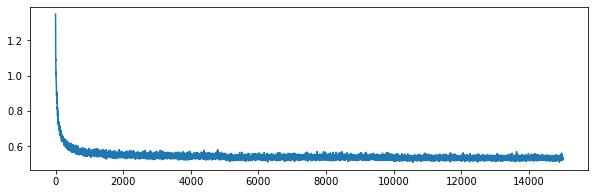

idx 290
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1190/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.00033813509052980364 0.011996185212154554
std_all 0.026618489957573058 0.0098794488953373
mean_all 0.0010802067964329407 0.007101346594686648
std_all 0.02991751960904799 0.01958939042075746
mean_all 0.0001346455384577777 0.010639347910553137
std_all 0.027718166508064704 0.01397863809654138
[0.26106906 0.35530717 0.42623906 0.48939729 0.54494701 0.59646861
 0.63533165 0.66690371 0.69467815 0.71748997 0.73817759 0.75628992
 0.77354777 0.7891747  0.80407517 0.81831308 0.83043084 0.84188927
 0.85269977 0.86242693]
(81, 81)
[0.2276244  0.36086996 0.47621801 0.58528023 0.66379387 0.7143669
 0.76189352 0.8024507  0.83374196 0.85750098 0.87724455 0.89373066
 0.90711107 0.91823458 0.92768414 0.9361446  0.94350346 0.94993336
 0.95566634 0.96042869]
(64, 81)
[0.23958727 0.33610801 0.41706857 0.48378617 0.54667365 0.59535022
 0.63486794 0.67074666 0.70019246

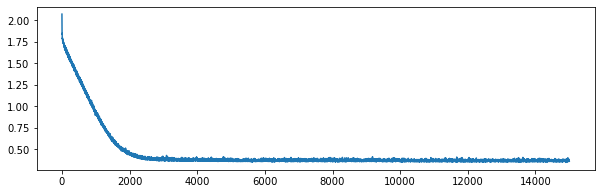

idx 295
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1190/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0013604278264973736 0.014873218243424068
std_all 0.03270911028064434 0.009803372011818603
mean_all 0.003097775070595061 0.01256932707119807
std_all 0.04186216071663393 0.016135799985886507
mean_all 0.00012563980586677154 0.01430225631271234
std_all 0.03576012709264088 0.013018300814766681
[0.25431977 0.37129094 0.44127988 0.50662381 0.56211563 0.60746726
 0.64189958 0.67336405 0.70215498 0.72660438 0.74853303 0.767102
 0.78377002 0.79957124 0.81358803 0.82682469 0.83919309 0.85022222
 0.86033615 0.87032561]
(81, 81)
[0.28986162 0.43579974 0.54194818 0.62993324 0.69206529 0.74645591
 0.79517304 0.82879218 0.85752065 0.88235881 0.89969324 0.91331417
 0.92480732 0.93590051 0.94521541 0.95361972 0.95981585 0.96482338
 0.96938007 0.97325065]
(64, 81)
[0.25256555 0.36884211 0.43996501 0.50005666 0.55880226 0.60829768
 0.64974749 0.685

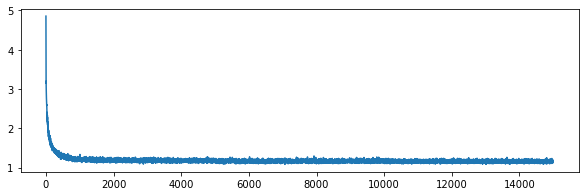

idx 300
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1191/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0002528193596068458 0.00782652154371862
std_all 0.022659182173817214 0.007502302706701349
mean_all 0.0007673287784006119 0.004372802225560227
std_all 0.0252704974841162 0.01846289773764268
mean_all 8.723001972897353e-05 0.006887768863107219
std_all 0.02352962061058354 0.012355749850573068
[0.194399   0.2797976  0.34050767 0.39864604 0.44761082 0.49114446
 0.5319715  0.56781914 0.60042751 0.62926879 0.65389026 0.67738791
 0.69970903 0.72090849 0.73899518 0.75664635 0.77317491 0.78859511
 0.80239911 0.81522549]
(81, 81)
[0.16693849 0.30354954 0.41781983 0.5216234  0.60742088 0.67282007
 0.71996472 0.75905932 0.7927379  0.82297109 0.84593228 0.8650133
 0.88184419 0.89713582 0.91149638 0.92305205 0.93307793 0.94174038
 0.94983161 0.95627855]
(64, 81)
[0.16396048 0.2545199  0.33723236 0.40087675 0.46287696 0.5109192
 0.55259594 0.58867586 0.62199

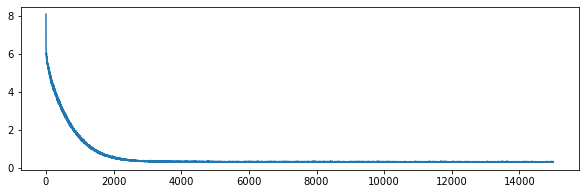

idx 305
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1254/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.000720707621732383 0.013682576119557664
std_all 0.028816250337811176 0.009618757655276958
mean_all 0.0017300080198054465 0.012116260737232374
std_all 0.02961155396959562 0.01182115386270398
mean_all 9.619759211356007e-05 0.0132316987767763
std_all 0.02908135154840599 0.01041156965781773
[0.20426093 0.29409228 0.37436517 0.44073389 0.49215593 0.54251127
 0.58365245 0.61704892 0.64520875 0.66974914 0.69093142 0.71132939
 0.7292257  0.74672914 0.76098184 0.77500431 0.78842208 0.80014025
 0.81031583 0.81997846]
(81, 81)
[0.34040601 0.46747795 0.55453382 0.63363036 0.68824927 0.72827871
 0.76548939 0.7951752  0.82229829 0.83978977 0.85575701 0.87041845
 0.88270731 0.8937228  0.9029564  0.91069667 0.91772078 0.92395476
 0.92997446 0.93535833]
(81, 81)
[0.24490945 0.34022983 0.41780071 0.4852517  0.53692689 0.58119284
 0.62001855 0.651817

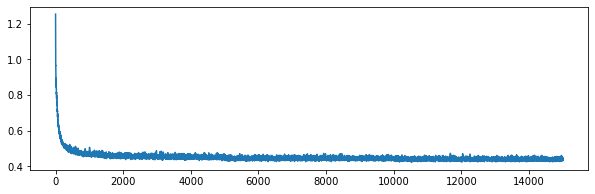

idx 310
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1254/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0006171314402347752 0.014191990720649002
std_all 0.02838921255861102 0.01358116081338537
mean_all 0.000978063069810746 0.010494284596313266
std_all 0.027606073528807624 0.021658799878645465
mean_all -8.539993688626815e-05 0.013097730602007767
std_all 0.028128166215343225 0.01671733971481191
[0.2095867  0.29281734 0.36968325 0.44043094 0.49157623 0.53528173
 0.56987284 0.59939646 0.62459349 0.64968891 0.67203602 0.69282991
 0.71252424 0.73040855 0.74586581 0.75987378 0.77226274 0.78415865
 0.79466109 0.8047936 ]
(81, 81)
[0.28123648 0.40297551 0.51018565 0.58839138 0.64524977 0.69106177
 0.72914899 0.76033333 0.7867379  0.81081484 0.82778148 0.84336528
 0.85605938 0.86810062 0.87827635 0.88784002 0.89618034 0.90391358
 0.91073803 0.916586  ]
(81, 81)
[0.22962698 0.31884791 0.39964539 0.47568272 0.52434483 0.56995401
 0.60361529 0.63161714 0.65

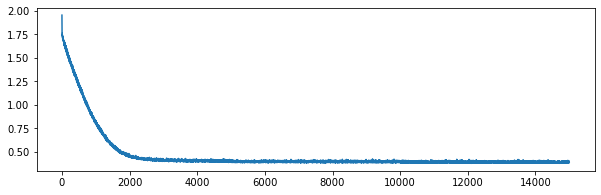

idx 315
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1255/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006493049255009494 0.017422027375891342
std_all 0.0325807564160124 0.011048684035863508
mean_all 0.001416063272385371 0.016900695947134437
std_all 0.03889744329609848 0.016267049486274013
mean_all 3.915114046115761e-05 0.017277455732819972
std_all 0.03468631870937442 0.013358693701917435
[0.22690724 0.32855907 0.39945806 0.4580759  0.50497329 0.54164668
 0.57753139 0.60963113 0.6359973  0.6605433  0.68229847 0.70282962
 0.72155401 0.73914944 0.75393918 0.76840616 0.78163822 0.79413944
 0.80558426 0.81607892]
(81, 81)
[0.30463582 0.43509629 0.52527061 0.60645939 0.66135144 0.71250947
 0.74994166 0.78511068 0.8156166  0.83577539 0.85432394 0.86831666
 0.88206885 0.89207785 0.90128686 0.9092727  0.9159901  0.92259818
 0.92891412 0.93472259]
(81, 81)
[0.24411898 0.34892487 0.42240297 0.48841761 0.53139649 0.57006469
 0.60732309 0.63978

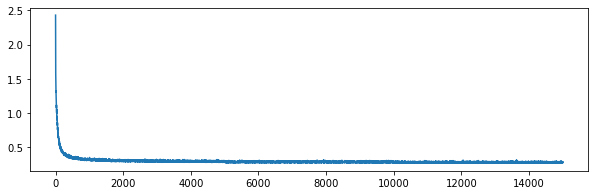

idx 320
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1318/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00016941152234876608 0.011217778597920922
std_all 0.024009864319801007 0.009997983937302151
mean_all 0.0004137461287089164 0.00897775584674671
std_all 0.025321494056382475 0.02049068106421484
mean_all 2.4974361337128118e-05 0.01052780332608847
std_all 0.02444707423199483 0.014386733369559602
[0.20116585 0.30108691 0.38119319 0.42743097 0.47253206 0.50536052
 0.53681625 0.5646517  0.58995622 0.61244512 0.63171057 0.64987905
 0.66641892 0.68232705 0.69732501 0.71030129 0.72249469 0.73349012
 0.74393005 0.75359624]
(81, 81)
[0.27062998 0.38772154 0.47614145 0.5500489  0.60154696 0.64111998
 0.6750576  0.70730516 0.73737962 0.75855575 0.77574416 0.79163189
 0.8063742  0.81933257 0.83119994 0.84169644 0.85129765 0.86027882
 0.86820953 0.87573313]
(81, 81)
[0.21970893 0.31432186 0.39999861 0.45442385 0.49865385 0.53434514
 0.56443266 0.59266633 0.6178

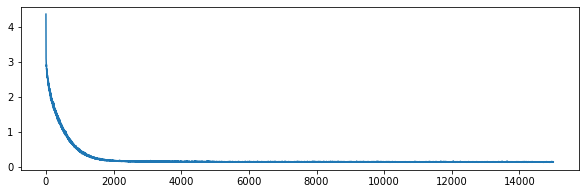

idx 325
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1318/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0003959983807943685 0.012241174753329845
std_all 0.023887491476876768 0.010096730280854177
mean_all 0.0007604824280742438 0.012889395449530163
std_all 0.029944357624238582 0.011284765430755541
mean_all -1.0504777838164333e-05 0.012472915532531676
std_all 0.025906446859330703 0.010888693533108078
[0.18907877 0.27805297 0.34642101 0.40011589 0.44425497 0.48444263
 0.51707771 0.5473163  0.57330237 0.59563735 0.61649108 0.63626021
 0.65450409 0.6711796  0.6861266  0.70095019 0.71430632 0.72674748
 0.73861076 0.75000306]
(81, 81)
[0.34557316 0.48304311 0.57473337 0.6417329  0.69704619 0.73318619
 0.76597057 0.79417853 0.81818002 0.83397192 0.84863029 0.86086328
 0.87107051 0.88106183 0.8895277  0.89742006 0.90470601 0.91115902
 0.9170095  0.92232636]
(81, 81)
[0.23114935 0.33142046 0.40026967 0.46265505 0.50709721 0.54515587
 0.5769

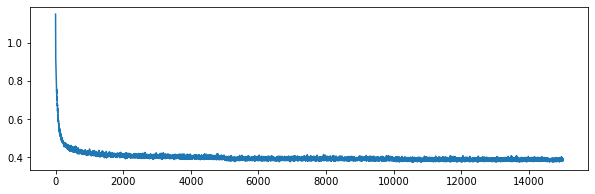

idx 330
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1319/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0008332412393316493 0.012525559123334059
std_all 0.02557921166558019 0.011749150387336385
mean_all 0.0005366892145577921 0.010818365033455343
std_all 0.028883828624292455 0.020806756210704644
mean_all -0.00037659775470183553 0.012000936412542879
std_all 0.026680750651817613 0.015451930866285456
[0.20498236 0.2915587  0.36310196 0.41076985 0.45411988 0.49071065
 0.52281955 0.55174386 0.57770325 0.60045914 0.62070815 0.63885487
 0.65664154 0.67252041 0.68770129 0.70238106 0.71565625 0.72708861
 0.73834418 0.74843415]
(81, 81)
[0.26827801 0.406715   0.48708953 0.55954828 0.61152647 0.64895898
 0.68401513 0.71565543 0.74490435 0.76587935 0.78331783 0.80031462
 0.81443017 0.82836748 0.84114251 0.85131878 0.86014709 0.86827357
 0.87595861 0.8828999 ]
(81, 81)
[0.2223605  0.32113624 0.39483546 0.44680577 0.49239552 0.52848397
 0.56142498 0.58897889 0.61

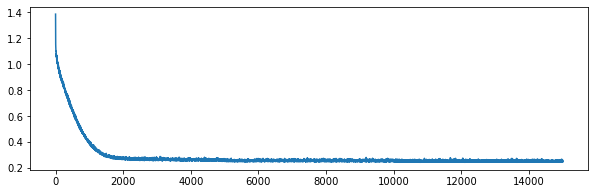

idx 335
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1319/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0010539634066823148 0.014870608054152645
std_all 0.029094606212745934 0.011515112746851346
mean_all 0.0007903299298802212 0.015965702904937613
std_all 0.035415014148798746 0.013218873808603721
mean_all -0.00043919896116146944 0.015269154626130549
std_all 0.031201408858096875 0.012470845630669055
[0.19134637 0.29798721 0.37596274 0.43155355 0.48007145 0.52078468
 0.55971159 0.58970236 0.61397342 0.63739811 0.65801638 0.67796096
 0.6960538  0.71235191 0.72696196 0.74072171 0.7540846  0.76685149
 0.77787192 0.78825611]
(81, 81)
[0.32816996 0.48395695 0.56674325 0.64113699 0.68328083 0.72027656
 0.75121862 0.78084099 0.80902441 0.82754832 0.84391014 0.85778528
 0.8708557  0.88209715 0.89077826 0.89839198 0.90532437 0.91204778
 0.91758504 0.92274926]
(81, 81)
[0.231226   0.34808306 0.42387679 0.48290172 0.5277548  0.56737287
 0.60396

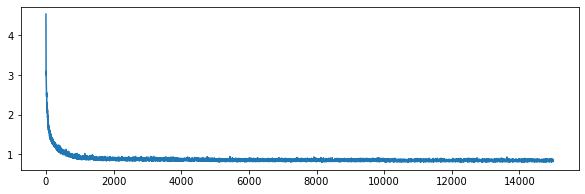

idx 340
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1382/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0003510420094271617 0.010975094035170463
std_all 0.024390652686266133 0.011980222480880777
mean_all 0.00023852461333650772 0.004479738936947383
std_all 0.022497213366306508 0.02006075982893126
mean_all -0.00015451980183927205 0.009331044331929883
std_all 0.023759506246279594 0.015186349366773554
[0.20978733 0.3244807  0.42242591 0.49092094 0.54869455 0.59759788
 0.63818904 0.67052045 0.69929121 0.72383868 0.74655751 0.76773768
 0.78584371 0.80173284 0.81720113 0.8311089  0.84369946 0.8547602
 0.86515378 0.87460137]
(81, 81)
[0.18266781 0.31865647 0.43105164 0.5232742  0.59676056 0.66465706
 0.72038483 0.75866124 0.79134144 0.81988971 0.84399174 0.86368431
 0.88143358 0.89572993 0.90824488 0.91857943 0.92735533 0.93574441
 0.94288882 0.94980602]
(64, 81)
[0.18053644 0.294218   0.39335135 0.46719163 0.52118012 0.57057031
 0.61889146 0.65526414

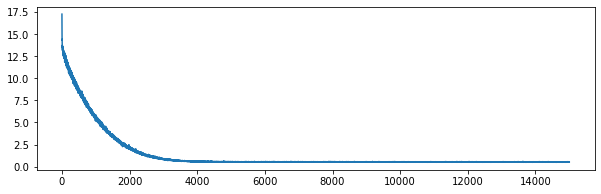

idx 345
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1383/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.001510154935003447 0.016940316227205612
std_all 0.03122398766977722 0.011239816025940302
mean_all 0.0023767328659619297 0.011972691760708896
std_all 0.03157039083746221 0.012588394279259136
mean_all -0.000214525668014988 0.01557097628000313
std_all 0.031339455392338886 0.011707755206041484
[0.26257066 0.35674216 0.42992204 0.49692197 0.55105109 0.59065302
 0.62626597 0.65909085 0.69040592 0.715661   0.73937035 0.75981129
 0.77941597 0.79685542 0.8133796  0.82797022 0.84107772 0.85211285
 0.86247321 0.8720907 ]
(81, 81)
[0.36711274 0.48734689 0.58796083 0.68027457 0.73603633 0.7826798
 0.82390531 0.85697152 0.87854881 0.89714291 0.91345697 0.92451407
 0.93416908 0.94135379 0.94842085 0.95482362 0.95997071 0.96412409
 0.96796867 0.97134253]
(64, 81)
[0.29002796 0.38352535 0.46706902 0.53646517 0.58487034 0.62382992
 0.65867483 0.6899

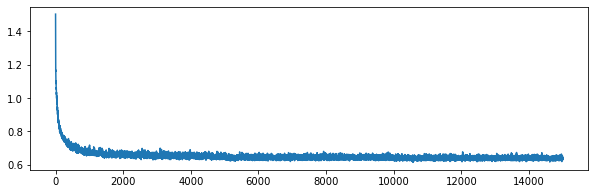

idx 350
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1383/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0013469499878611506 0.016611421290347362
std_all 0.025736888864833767 0.01021499699732926
mean_all 0.0011209845942493153 0.006201281516812526
std_all 0.024687893514440524 0.02309497435739735
mean_all -0.0005243051271576618 0.014075925007172387
std_all 0.02538722374803602 0.015735350457310695
[0.30451073 0.39650933 0.4627508  0.5182652  0.56302394 0.6005921
 0.63561103 0.66512446 0.691313   0.71334225 0.73319916 0.75283531
 0.77044712 0.78652608 0.80203821 0.81667861 0.82963656 0.84145277
 0.85256258 0.86338305]
(81, 81)
[0.27069088 0.43873373 0.54132006 0.62356122 0.68262437 0.72611681
 0.76683394 0.79915588 0.82595063 0.85164456 0.87359082 0.88847286
 0.90131239 0.91311788 0.92292267 0.93126354 0.93872566 0.94558018
 0.9511467  0.95613827]
(64, 81)
[0.28539324 0.37726902 0.45154941 0.51938462 0.57205738 0.61306813
 0.64786895 0.67662045 0.70

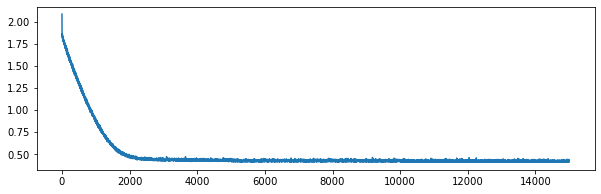

idx 355
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1446/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0008504877989406567 0.017914814201142753
std_all 0.03440458222286799 0.011486877232501917
mean_all 0.0018340774473848982 0.016325416540355242
std_all 0.037392028410590555 0.015921984385847646
mean_all 4.436728316786174e-05 0.017447110120273876
std_all 0.03540039761877551 0.013208030053830597
[0.23561234 0.34303243 0.40946872 0.46835822 0.51473339 0.5575598
 0.59031878 0.61979417 0.64395553 0.66565936 0.6869434  0.70672791
 0.7243724  0.74179872 0.7574103  0.77189144 0.78497399 0.79675985
 0.8081348  0.81895669]
(81, 81)
[0.340083   0.47868518 0.56771231 0.63656839 0.68991052 0.73522411
 0.76924125 0.80151287 0.82824032 0.84948908 0.8641195  0.87675048
 0.88757843 0.89752446 0.90668977 0.91517291 0.92279222 0.92903687
 0.93495235 0.94010838]
(81, 81)
[0.25978647 0.37217872 0.43739752 0.49842158 0.54713552 0.5899477
 0.62063022 0.6498

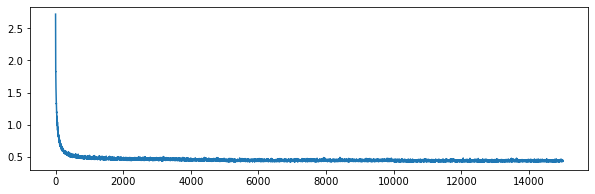

idx 360
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1447/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0011802201766615448 0.013046319510546535
std_all 0.02467959474667543 0.007604698995704169
mean_all 0.0010089765361567798 0.009194608230795247
std_all 0.02642714455892283 0.02003019483076856
mean_all -0.00045048793905543656 0.011946391099295104
std_all 0.0252621113507579 0.013151774939189339
[0.22637937 0.32183141 0.40392197 0.46712639 0.51357618 0.55263386
 0.58763678 0.61887358 0.64795579 0.67222817 0.69368774 0.71217913
 0.72892053 0.74487176 0.7598448  0.77408912 0.78760932 0.79806732
 0.80806841 0.81766527]
(81, 81)
[0.26136732 0.37272681 0.4700646  0.53587133 0.59880003 0.64999996
 0.69549832 0.72887479 0.75938372 0.77997482 0.79830397 0.81588218
 0.83105929 0.84369046 0.85610844 0.86731508 0.87795909 0.88722551
 0.89596061 0.90325523]
(81, 81)
[0.23213705 0.32988333 0.41137345 0.47104772 0.52229325 0.56078394
 0.5962064  0.62912264 0.65691

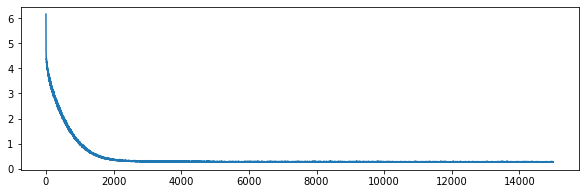

idx 365
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1447/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0014409390764864199 0.013345115628066367
std_all 0.026216143166336102 0.008666458234725477
mean_all 0.001394677505346606 0.012754192568053302
std_all 0.030724711023467327 0.012349581228797545
mean_all -0.0004957335492087445 0.0132188518317425
std_all 0.027718999118713172 0.010267726286390803
[0.20116451 0.30381103 0.37836886 0.44878073 0.49402534 0.53484612
 0.57047443 0.60282279 0.63195412 0.65632535 0.67713963 0.69762914
 0.71719977 0.73527696 0.75127085 0.76606421 0.77889434 0.79099256
 0.80212955 0.81288489]
(81, 81)
[0.34230384 0.46527236 0.53418909 0.60068612 0.65991609 0.71453925
 0.7544688  0.79082236 0.81782202 0.83641327 0.85150706 0.86466175
 0.87724952 0.88877893 0.89901978 0.9080563  0.9158735  0.92306812
 0.9295782  0.93510741]
(81, 81)
[0.23642982 0.33931805 0.41020852 0.47425844 0.51741389 0.5574637
 0.59397824 

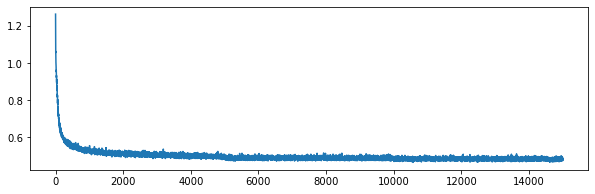

idx 370
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1510/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.00039191582800420915 0.014030717710046535
std_all 0.026524498450363254 0.010981797613447261
mean_all 0.0004010692054777333 0.009913419902902456
std_all 0.0273570892505985 0.020665164014301202
mean_all -0.00012758748351022833 0.012811676834454668
std_all 0.026802028717108337 0.01492995757615271
[0.20058833 0.28811575 0.35759373 0.4099956  0.45669141 0.49413256
 0.5298676  0.55951637 0.58545551 0.60916019 0.62961454 0.64834737
 0.66561295 0.68172357 0.69634379 0.70918802 0.72112968 0.73290472
 0.74343412 0.75315774]
(81, 81)
[0.25117436 0.37783426 0.46763891 0.54923105 0.60954061 0.65067108
 0.68509024 0.71849299 0.74956769 0.77399895 0.79462463 0.81165346
 0.8267226  0.84041998 0.85131968 0.86069439 0.8697857  0.87738633
 0.88469283 0.89131458]
(81, 81)
[0.21304243 0.30162967 0.38223753 0.44383697 0.49080868 0.52827942
 0.56079748 0.59054634 0.617

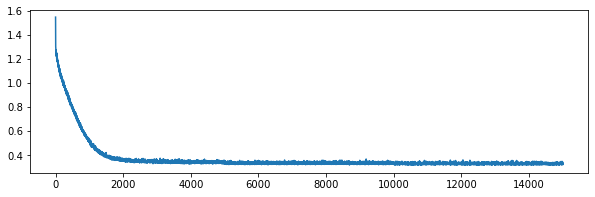

idx 375
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1510/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00047148201968329564 0.016752808186688055
std_all 0.02959938151656623 0.01186506088972778
mean_all 0.0008616794718651859 0.014907668291792239
std_all 0.034209239063898625 0.012363967927160689
mean_all -2.709485583380181e-05 0.01617340015670172
std_all 0.03113600069901036 0.012228303695510203
[0.18917907 0.27308155 0.34736884 0.40746285 0.45646181 0.49872058
 0.53143862 0.5620351  0.58818531 0.61332754 0.63700129 0.65765251
 0.67651813 0.69445989 0.71069588 0.72489816 0.73849133 0.75157884
 0.76380062 0.77497869]
(81, 81)
[0.31515605 0.4530243  0.54905895 0.61561293 0.67058697 0.71042205
 0.7473654  0.78252694 0.81131382 0.83454378 0.85041906 0.86432841
 0.87671151 0.88623461 0.89467344 0.90273739 0.90973365 0.91580893
 0.92169941 0.92714348]
(81, 81)
[0.22239211 0.31700608 0.38742338 0.45557899 0.50241407 0.54437956
 0.57761484 

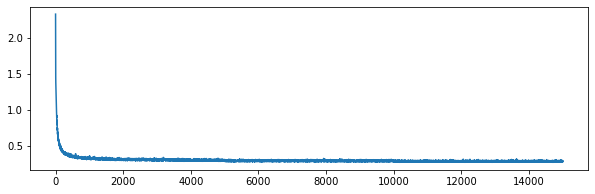

idx 380
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+0/baseidx1511/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0006154691078876594 0.011869307648804502
std_all 0.021344227233765216 0.008600260543273465
mean_all 0.0003623424025740882 0.00902910367329801
std_all 0.022464146635663356 0.017133020272014098
mean_all -0.0002895319377337435 0.011013976749270741
std_all 0.021717533701064592 0.012142288262882248
[0.21666337 0.30489538 0.38319692 0.43994337 0.48052159 0.51286016
 0.54340857 0.57261296 0.59672083 0.61799429 0.63736654 0.65389316
 0.66969292 0.68480996 0.69742939 0.70949974 0.72097147 0.73180095
 0.74206985 0.75199203]
(81, 81)
[0.27696996 0.3948139  0.47995648 0.55033015 0.60771737 0.64728058
 0.68271199 0.71348263 0.74246881 0.76165449 0.78002497 0.79564968
 0.80877617 0.82132943 0.83255592 0.8429619  0.85208517 0.86034002
 0.86819592 0.87553897]
(81, 81)
[0.23327325 0.32494409 0.40300738 0.46499225 0.50852403 0.54149638
 0.57200624 0.60088728 

In [10]:
collect_all()

In [11]:
# note that based on the loss curves, the approximation is not very successful.
# compared to local PCN-maskcnn or local PCN-imagenet

# check `/scripts/debug/feature_approximation`. The input distribution (mean and std) differences among these three
# settings cannot justify having 0.2~0.5 loss here while having 0.02 loss there 